<center><h1>Wong_Jonathan_HW6</h1></center>

Name: Jonathan Wong
<br>
Github Username: jonathanwong150@gmail.com
<br>
USC ID: 9171949586

## 1. Tree-Based Methods

Import packages

In [57]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import warnings
from imblearn.over_sampling import SMOTE
import itertools
import math
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
warnings.filterwarnings('ignore')

### (a) Download the APS Failure data

In [58]:
trainingData = pd.read_csv('../data/hw6_data/aps_failure_training_set.csv', skiprows=20, na_values='na')
testData = pd.read_csv('../data/hw6_data/aps_failure_test_set.csv', skiprows=20, na_values='na')

# Display the first few rows of the training data to verify it's loaded correctly
print("Training Data:")
print(trainingData)

# Display the first few rows of the test data to verify it's loaded correctly
print("\nTest Data:")
print(testData)


Training Data:
      class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2       neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
59995   neg  153002     NaN  6.640000e+02   186.0     0.0     0.0     0.0   
59996   neg    2286     NaN  2.130707e+09   224.0     0.0     0.0     0.0   
59997   neg     112     0.0  2.130706e+09    18.0     0.0     0.0     0.0   
59998   neg   80292     NaN  2.130706e+09   494.0     0.0     0.0     0.0   
59999   neg   40222     NaN  6.980000e+02   628.0     0.0     0.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003     ee_004  

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Imputation:
Mean/Median/Mode: Replace missing values with the mean, median, or mode of the column. 
Model-Based: Use a regression model to predict and fill in missing values based on the other features in the dataset.
K-Nearest Neighbors (KNN): Replace missing values using the mean value from 'k' nearest neighbors found in the training set.

Imputation Using Deep Learning:
Methods like autoencoders can be trained to learn the most probable imputation values based on the distribution of the data.

I will be using mean imputation because of it's advantages on univariate numeric data.

In [59]:
# Initialize the imputer to replace missing values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Apply the imputer to our data
# Excluding the first column which is the class label
trainingData.iloc[:, 1:] = imputer.fit_transform(trainingData.iloc[:, 1:])
testData.iloc[:, 1:] = imputer.transform(testData.iloc[:, 1:])

# Now, the missing values are replaced by the mean of their respective columns
print("Training Data:")
print(trainingData.head())

print("\nTest Data:")
print(testData.head())

Training Data:
  class  aa_000    ab_000        ac_000         ad_000  ae_000  af_000  \
0   neg   76698  0.713189  2.130706e+09     280.000000     0.0     0.0   
1   neg   33058  0.713189  0.000000e+00  190620.639314     0.0     0.0   
2   neg   41040  0.713189  2.280000e+02     100.000000     0.0     0.0   
3   neg      12  0.000000  7.000000e+01      66.000000     0.0    10.0   
4   neg   60874  0.713189  1.368000e+03     458.000000     0.0     0.0   

   ag_000  ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005  \
0     0.0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0   
1     0.0     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0   
2     0.0     0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0   
3     0.0     0.0     0.0  ...      240.0      46.0      58.0      44.0   
4     0.0     0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0   

     ee_006    ee_007    ee_008  ee_009  ef_000  eg_000  
0  339156.0  157956.0   73224.0

#### (ii) Calculate the coefficient of variation

In [60]:
featureCols = trainingData.columns[1:] 
cvVals = {}

for column in featureCols:
    meanVals = trainingData[column].mean()
    stdVals = trainingData[column].std()
    cv = stdVals / meanVals
    cvVals[column] = cv

# Print the CV for each feature
for feature, cv in cvVals.items():
    print(f"CV for {feature}: {cv}")

CV for aa_000: 2.4509375779439706
CV for ab_000: 2.328399987030788
CV for ac_000: 2.169766523276598
CV for ad_000: 183.84762036903672
CV for ae_000: 23.190936665590005
CV for af_000: 18.65892109601162
CV for ag_000: 91.87856462929975
CV for ag_001: 34.85495007772405
CV for ag_002: 17.369143404891002
CV for ag_003: 8.550049026710221
CV for ag_004: 5.40147869542194
CV for ag_005: 2.927092082425769
CV for ag_006: 2.344927070337641
CV for ag_007: 2.8334840909361785
CV for ag_008: 6.154583078552848
CV for ag_009: 32.98435104136501
CV for ah_000: 2.3001872486143595
CV for ai_000: 18.012681744456003
CV for aj_000: 43.80182238271064
CV for ak_000: 74.52668795867793
CV for al_000: 9.074370822655146
CV for am_0: 9.058671606115205
CV for an_000: 2.2387967743802824
CV for ao_000: 2.260149116812674
CV for ap_000: 3.0591643066388774
CV for aq_000: 2.8396116933654727
CV for ar_000: 10.837049702201314
CV for as_000: 86.4169038404694
CV for at_000: 23.459424790823903
CV for au_000: 68.16055401269416
CV

#### (iii) Plot a correlation matrix

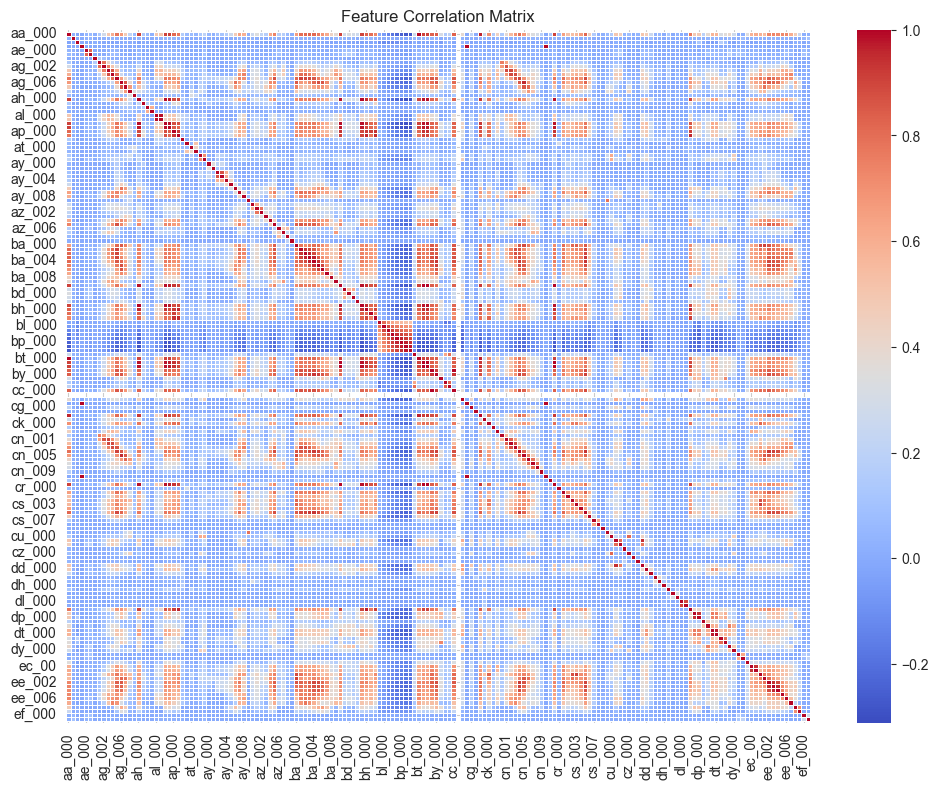

In [61]:
# Calculate the correlation matrix
corrMatrix = trainingData.iloc[:, 1:].corr()  # Exclude the class label for correlation

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a heatmap
sns.heatmap(corrMatrix, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5, ax=ax)

# Set the title
ax.set_title('Feature Correlation Matrix')

# Fix for matplotlib bug that cuts off top/bottom of seaborn viz
plt.ylim(len(corrMatrix)+0.5, -0.5)

plt.show()

#### (iv) Make scatter plots and box plots

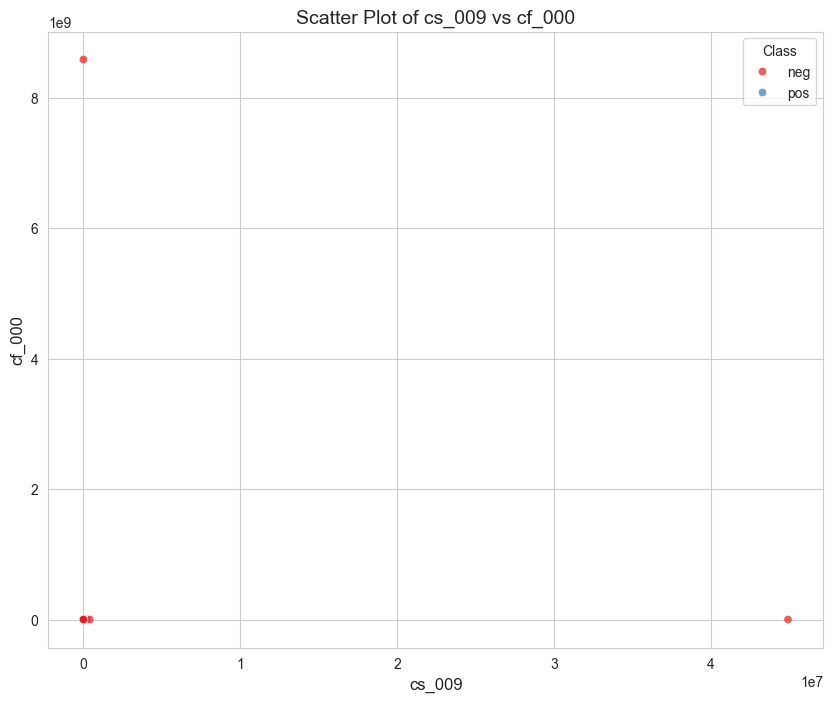

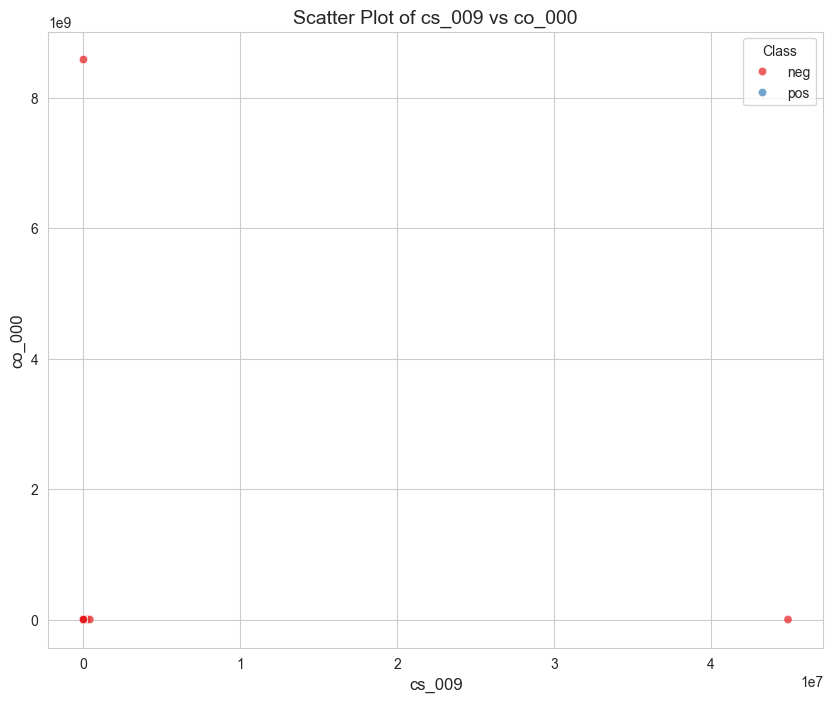

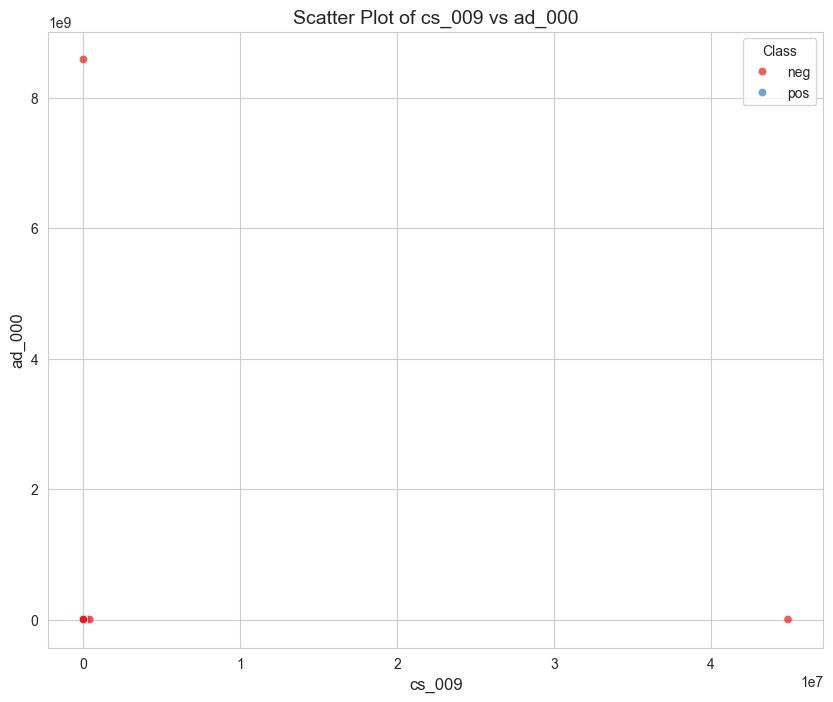

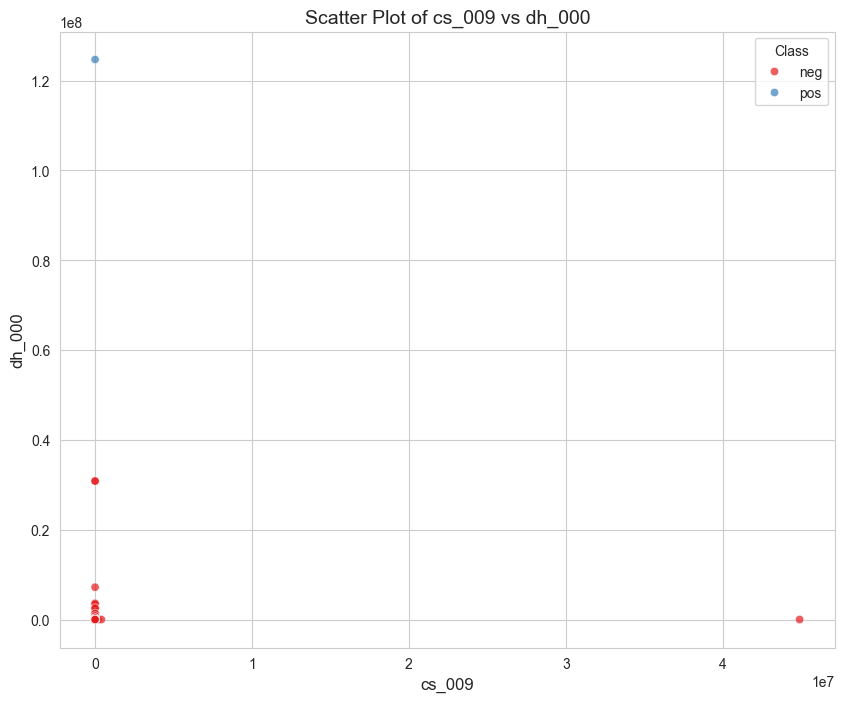

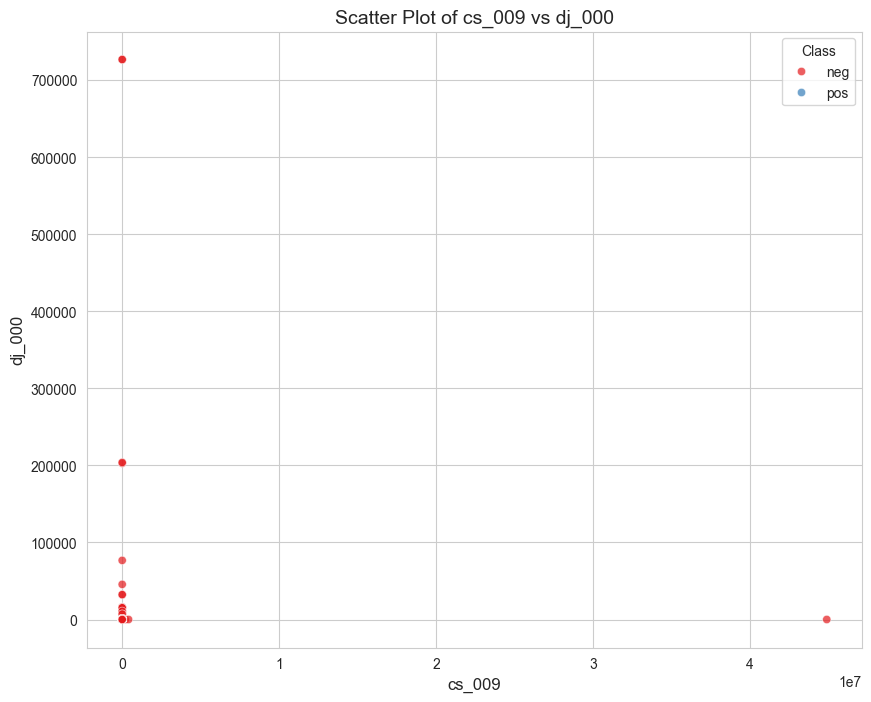

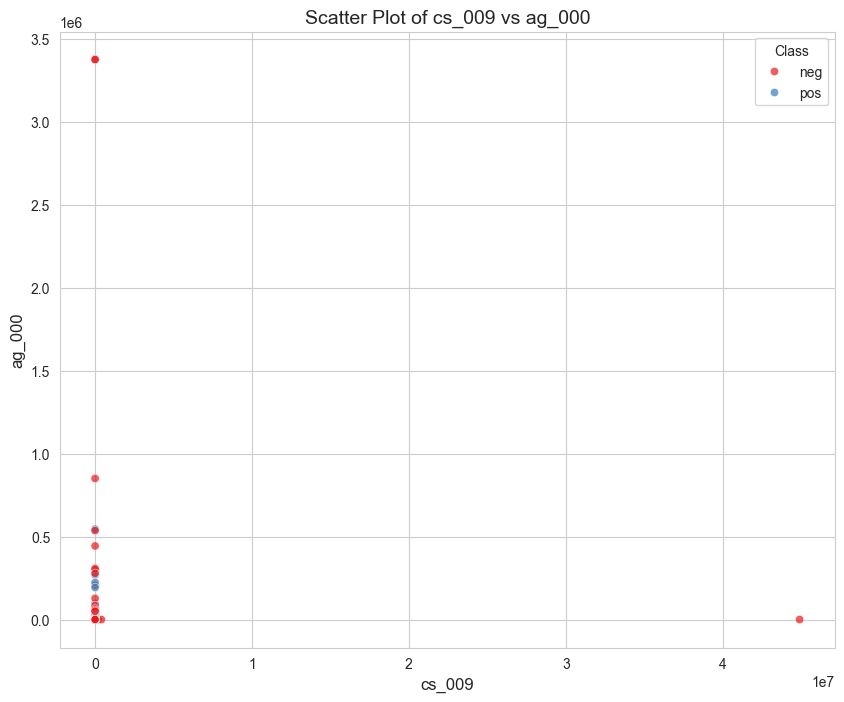

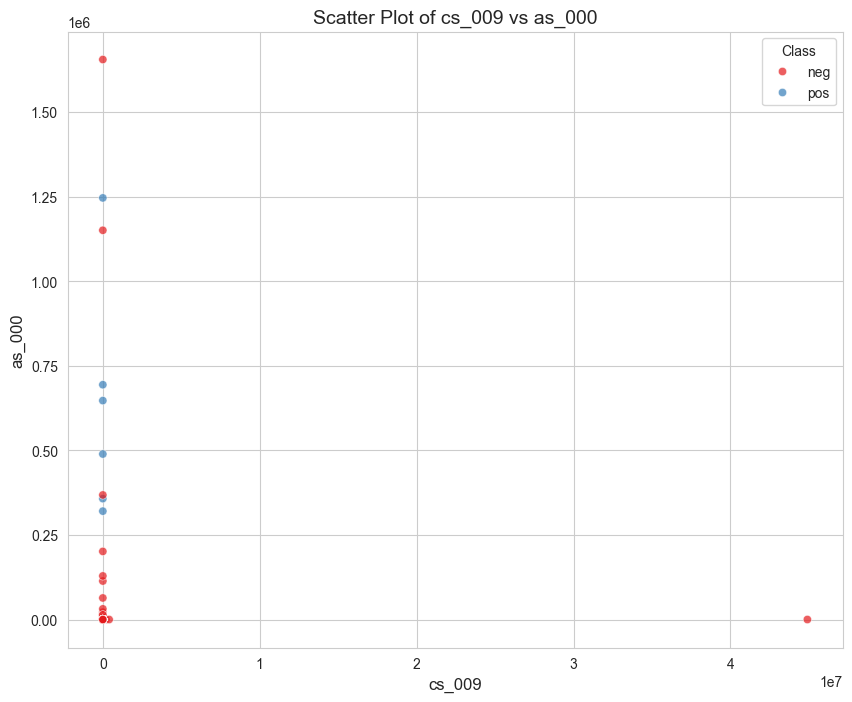

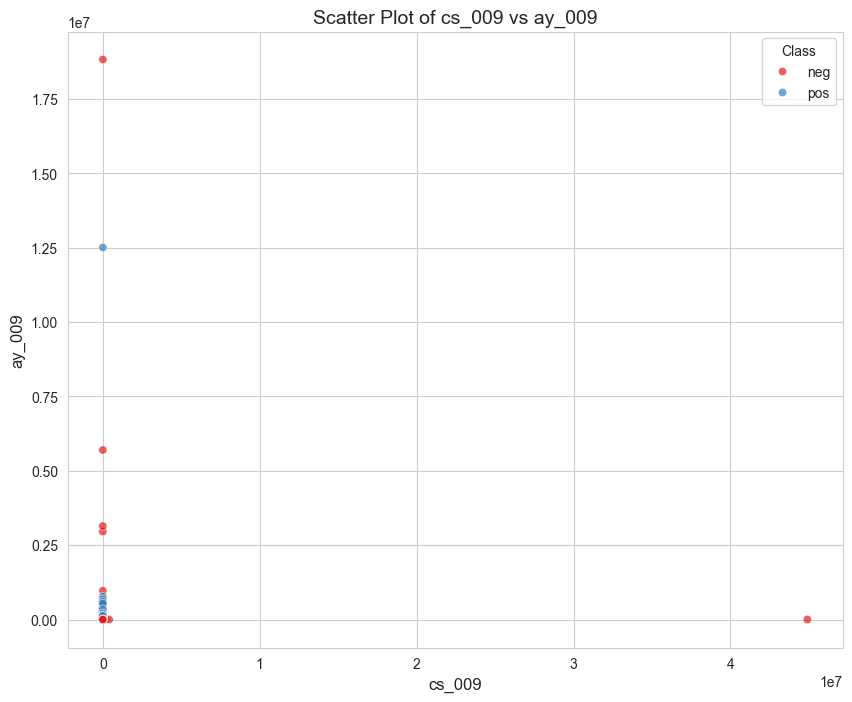

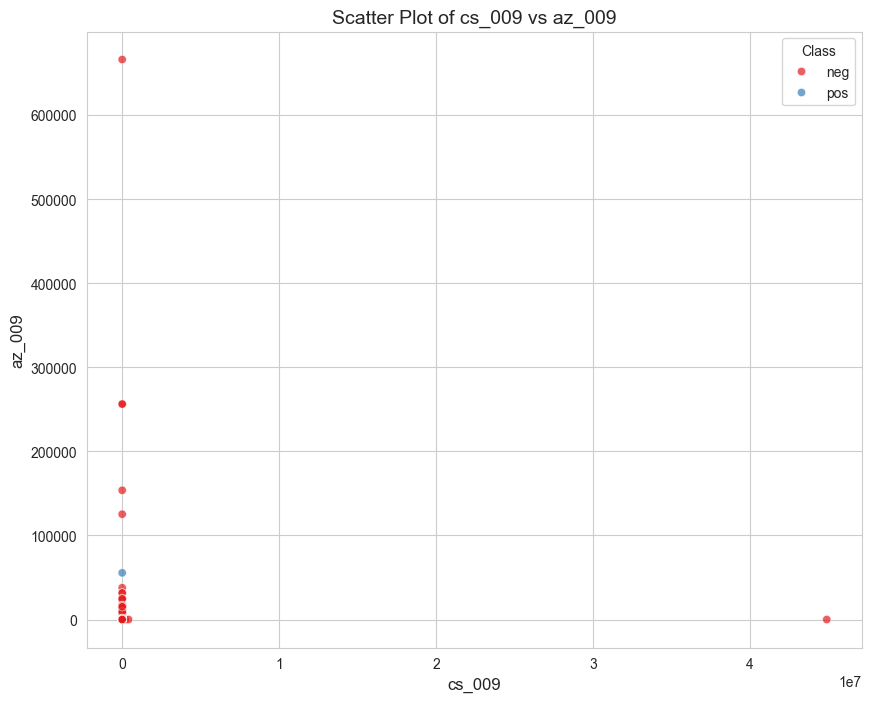

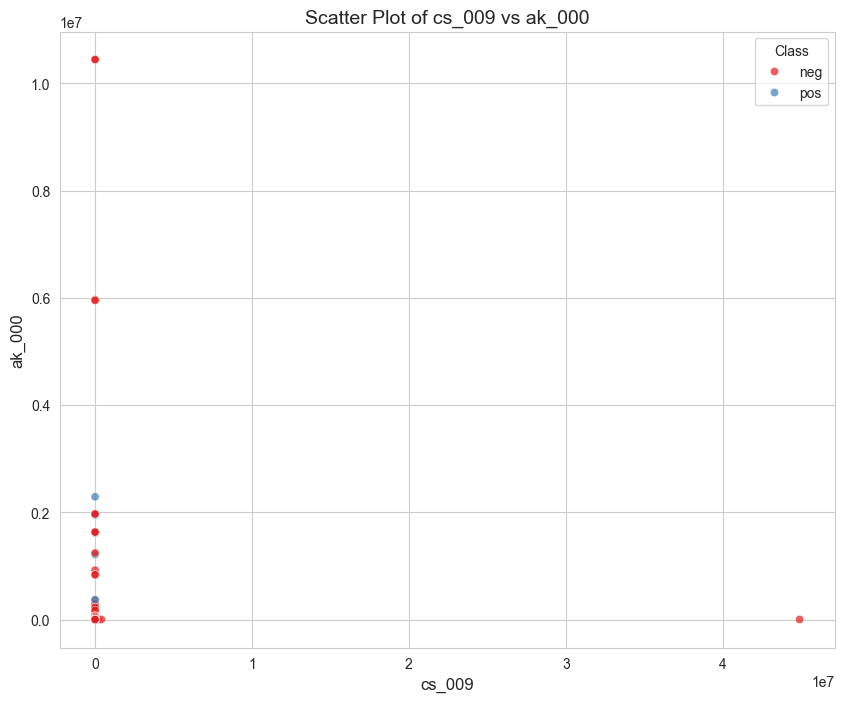

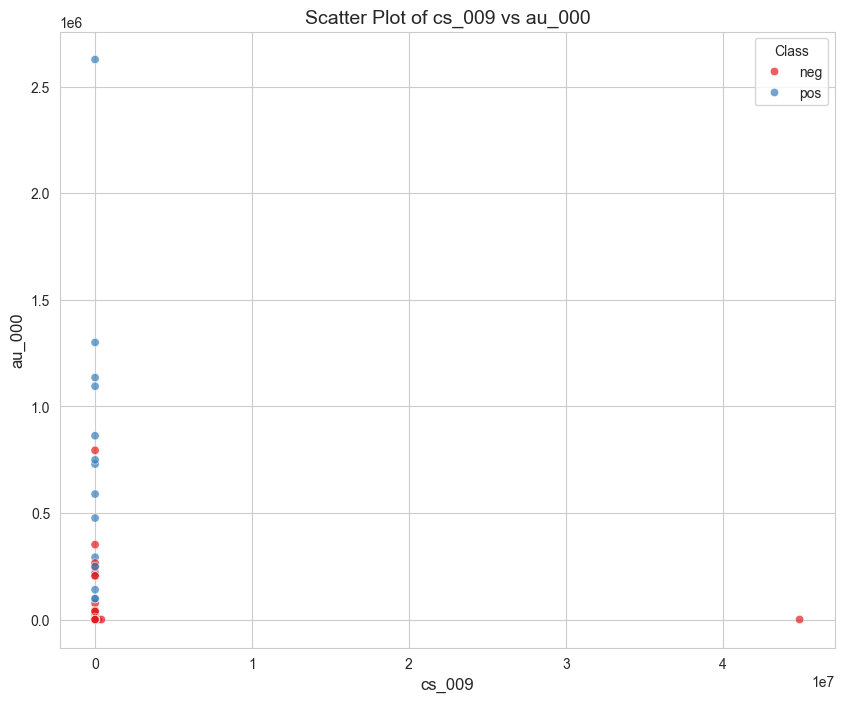

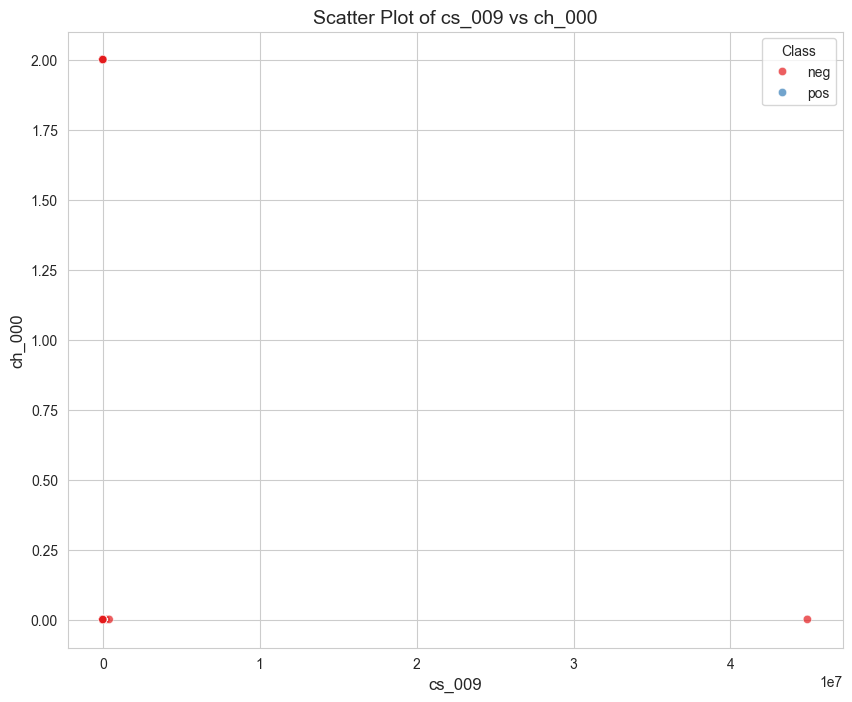

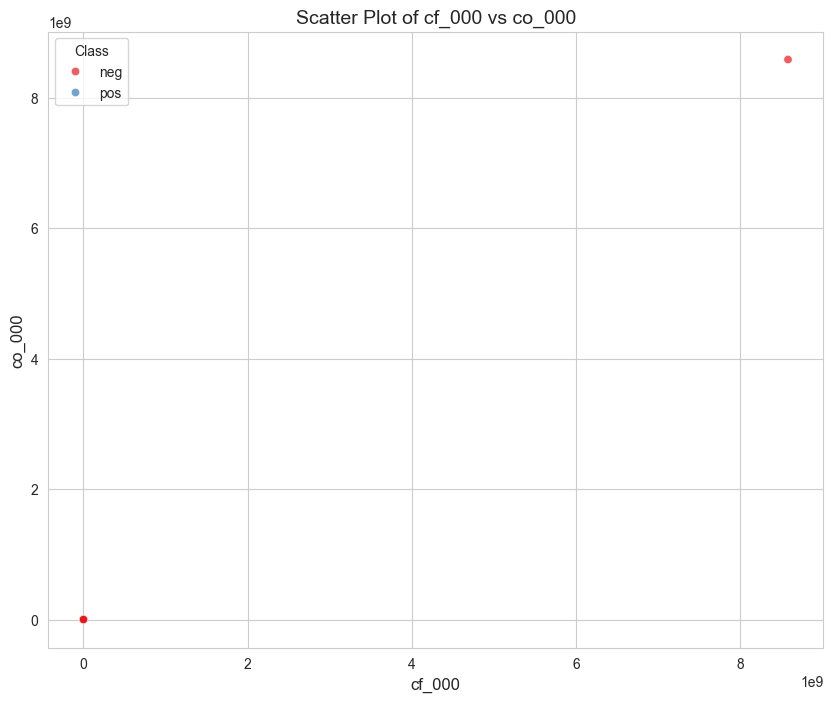

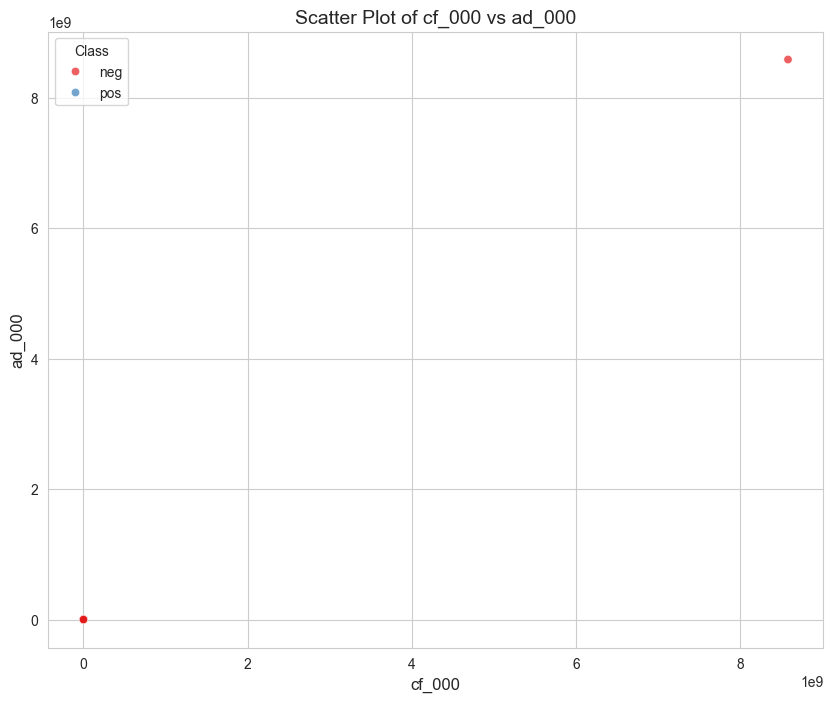

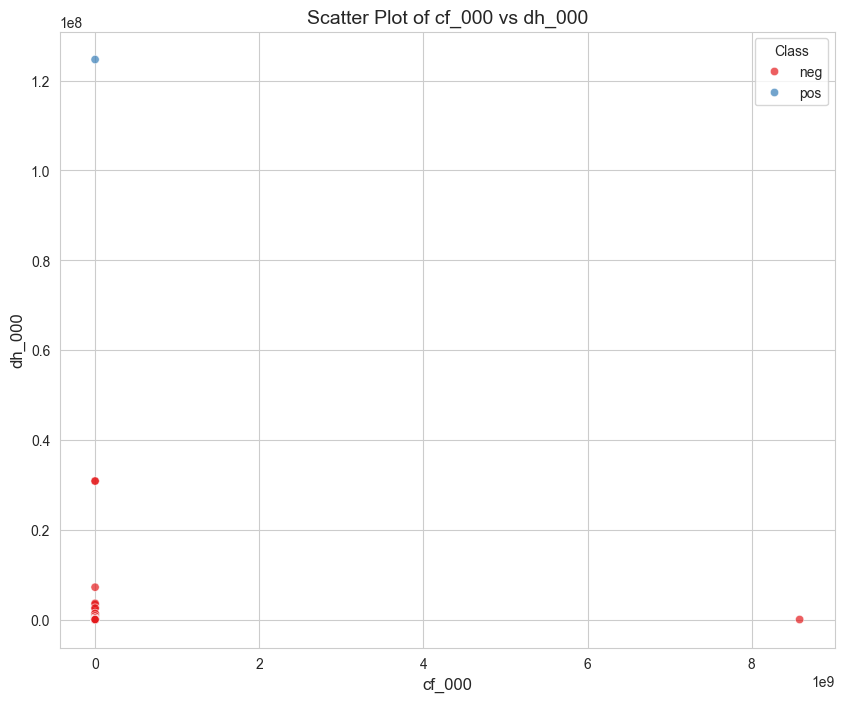

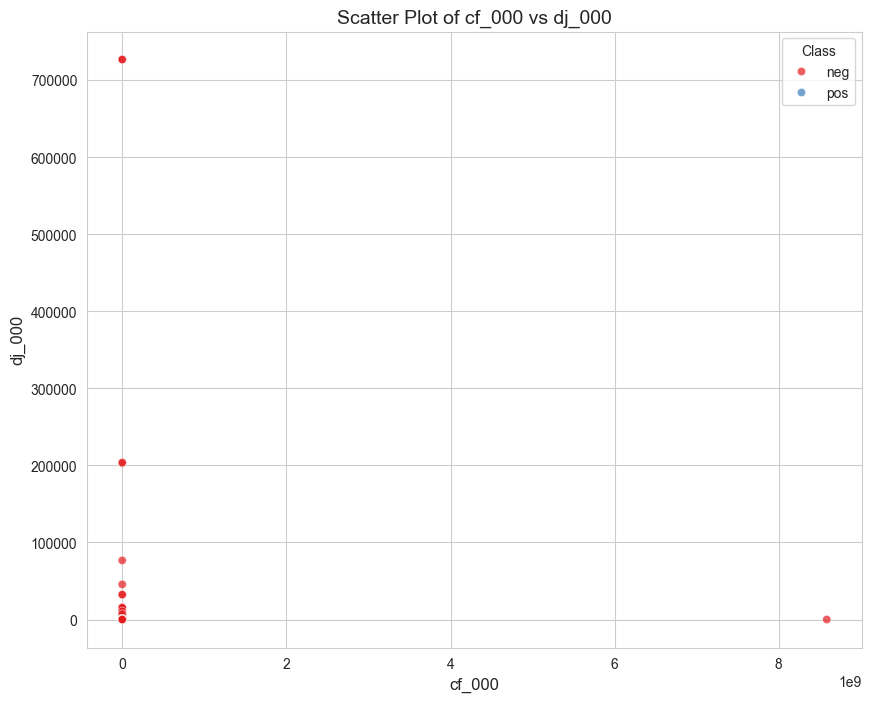

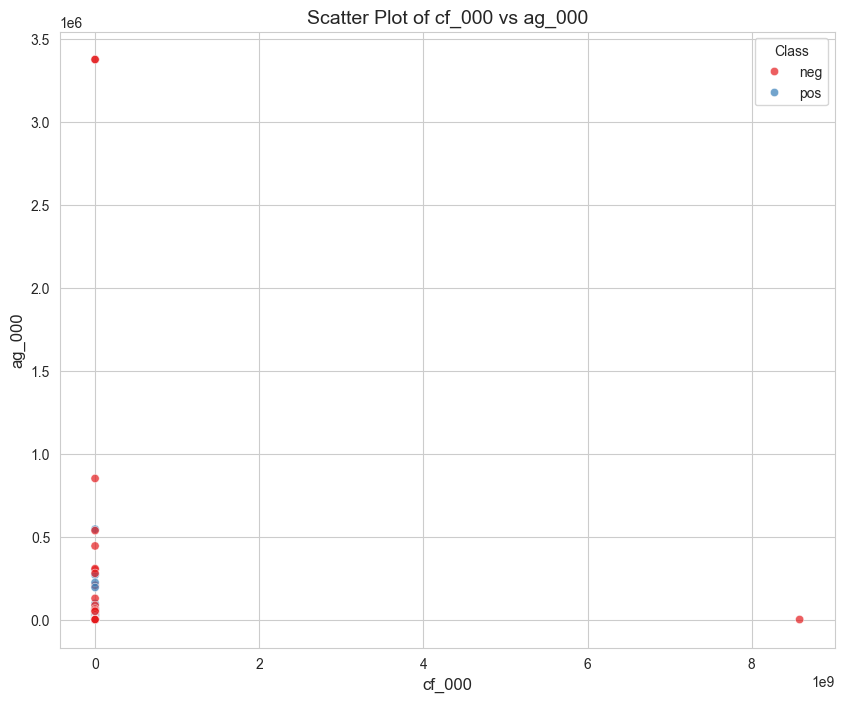

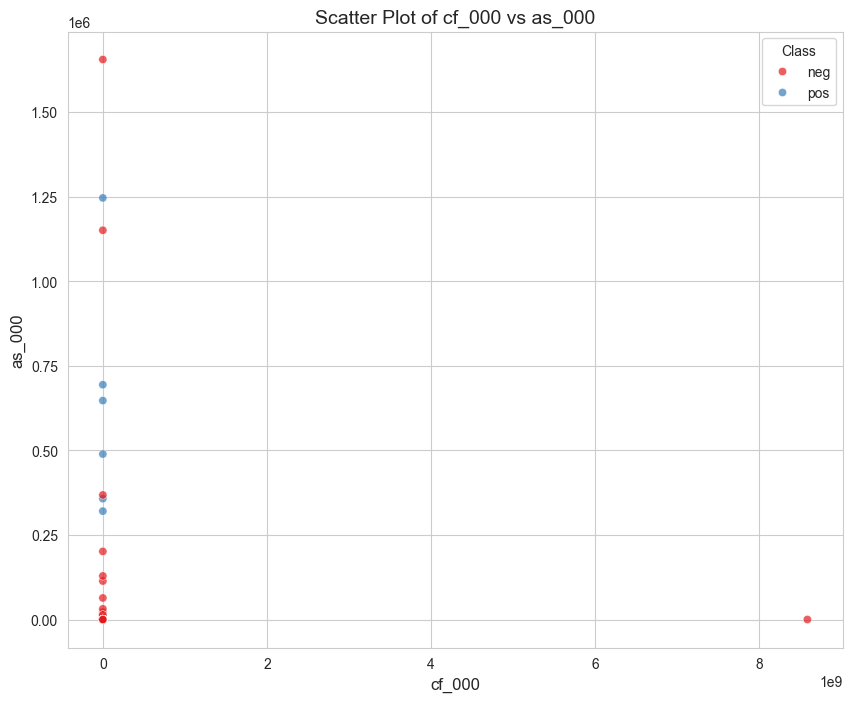

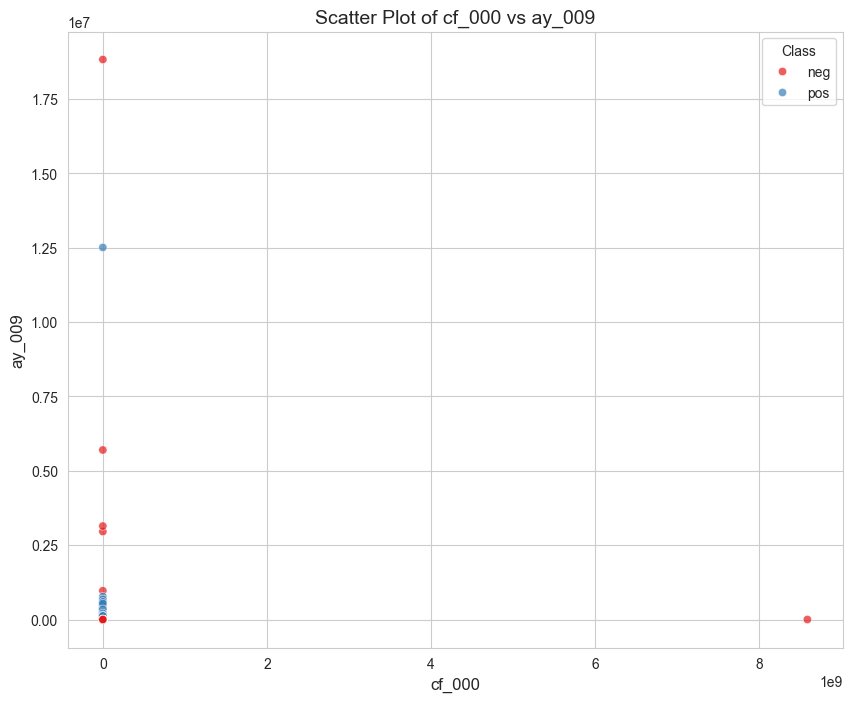

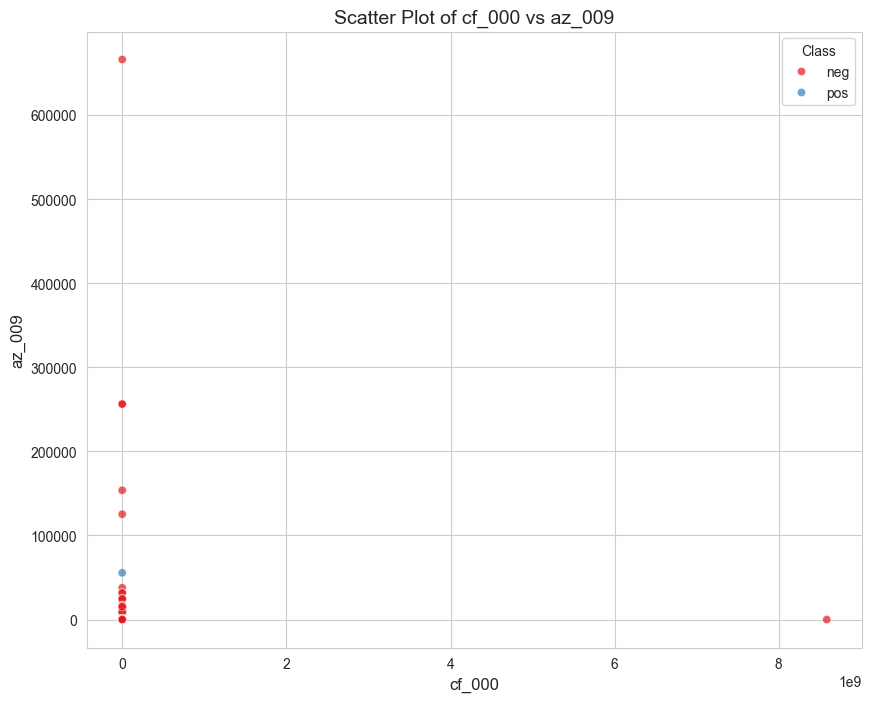

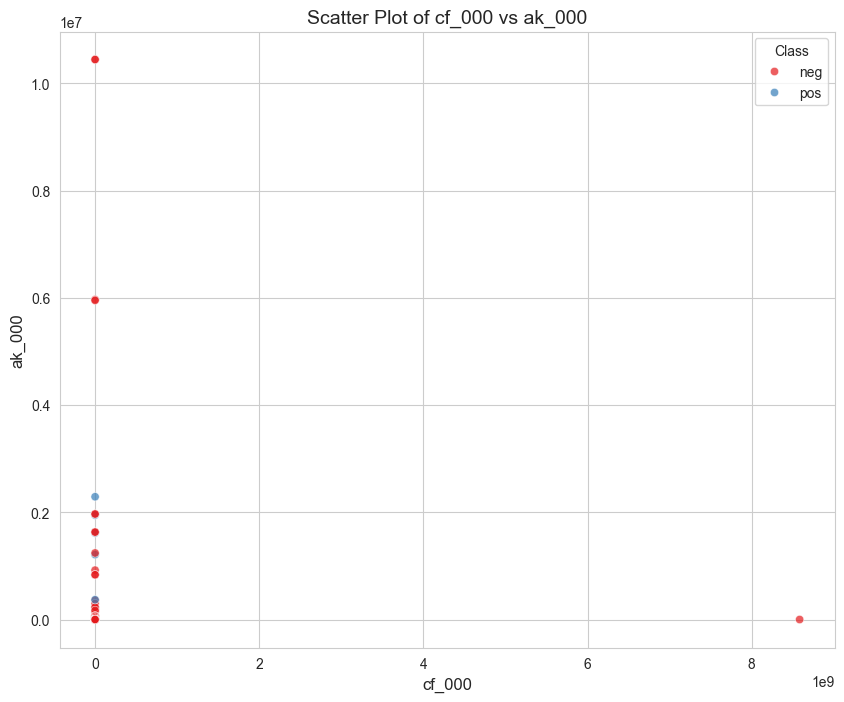

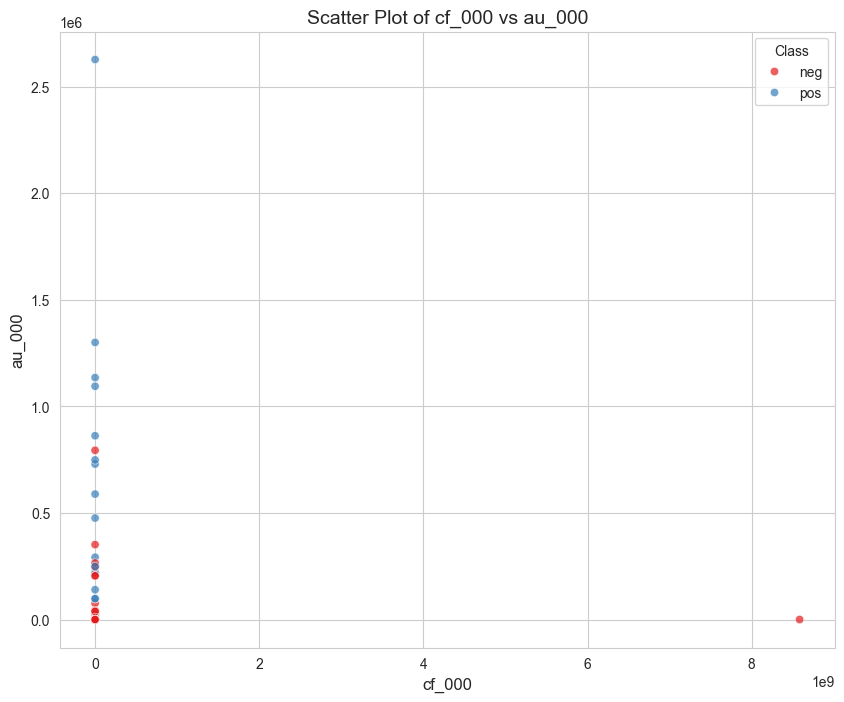

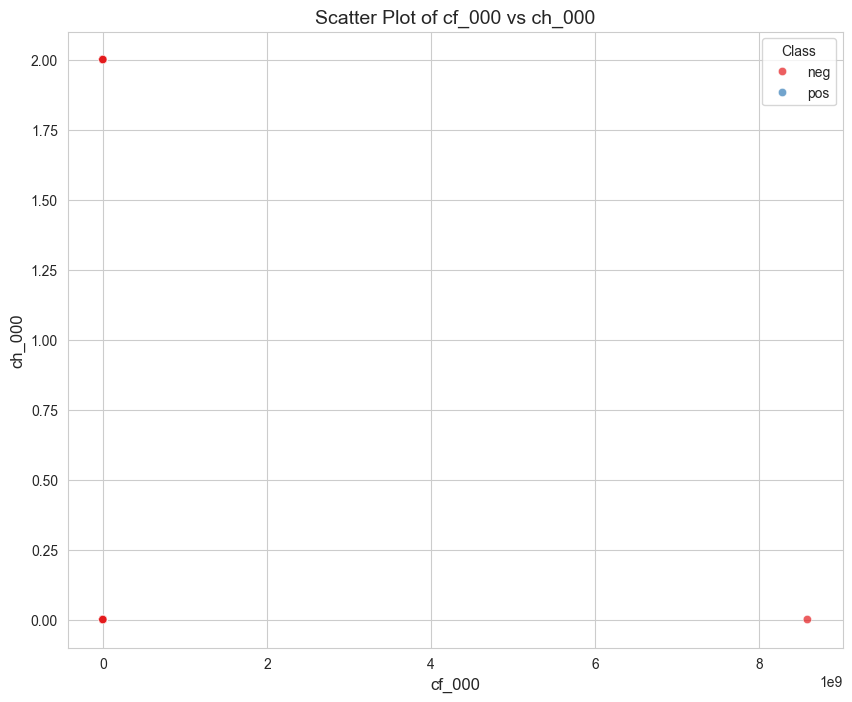

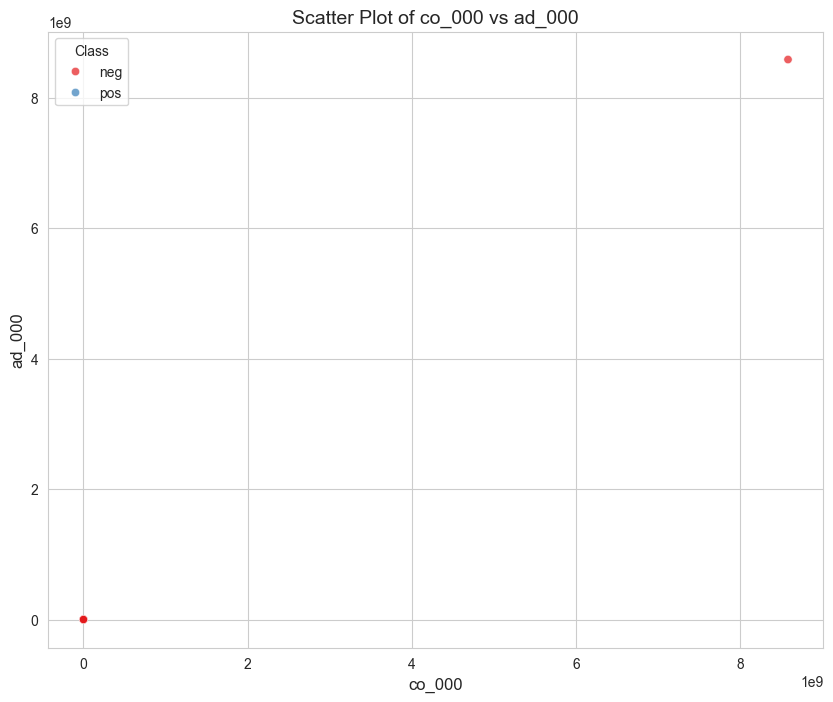

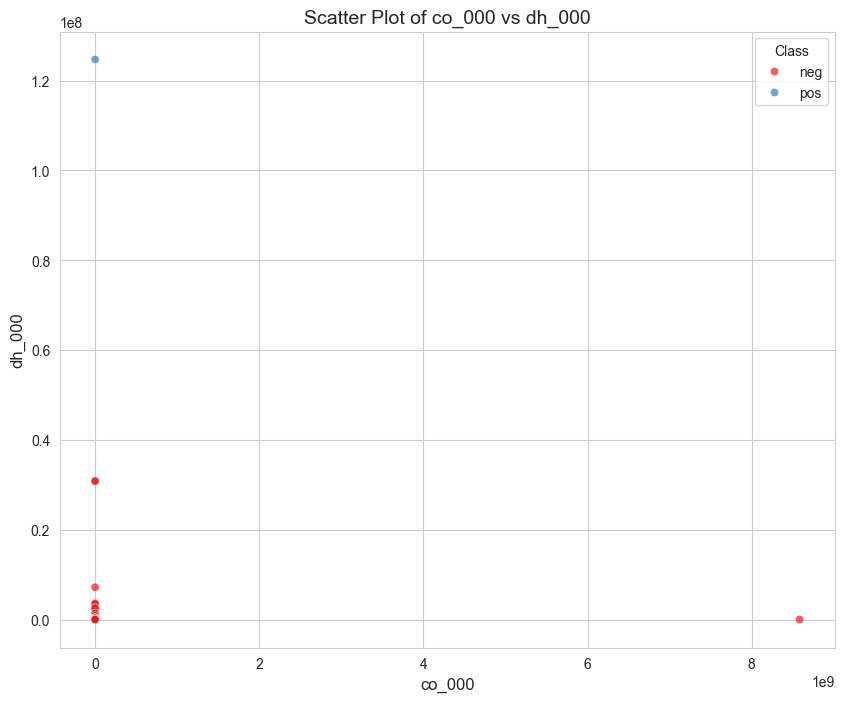

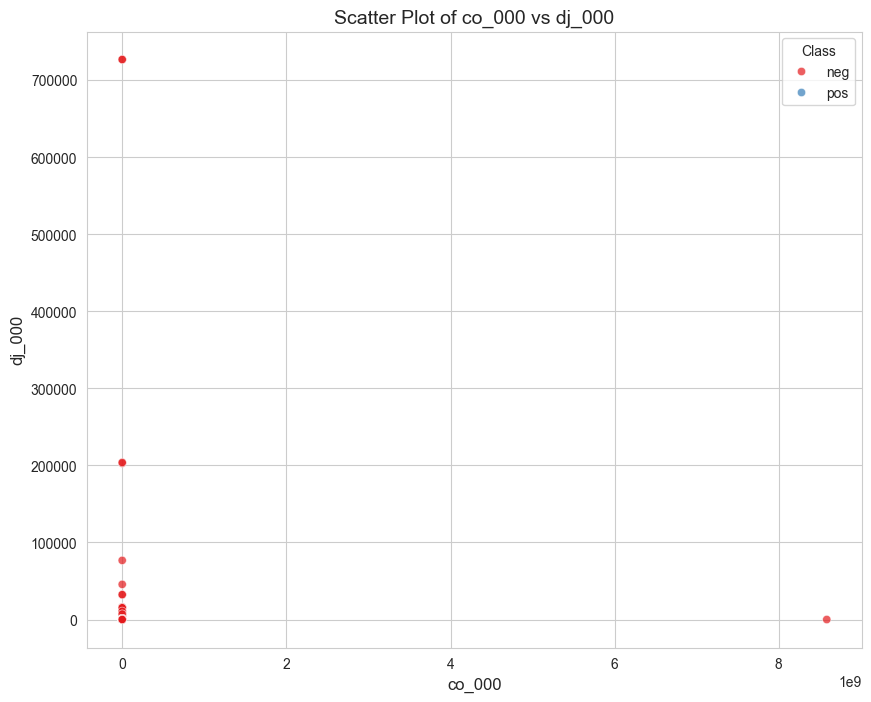

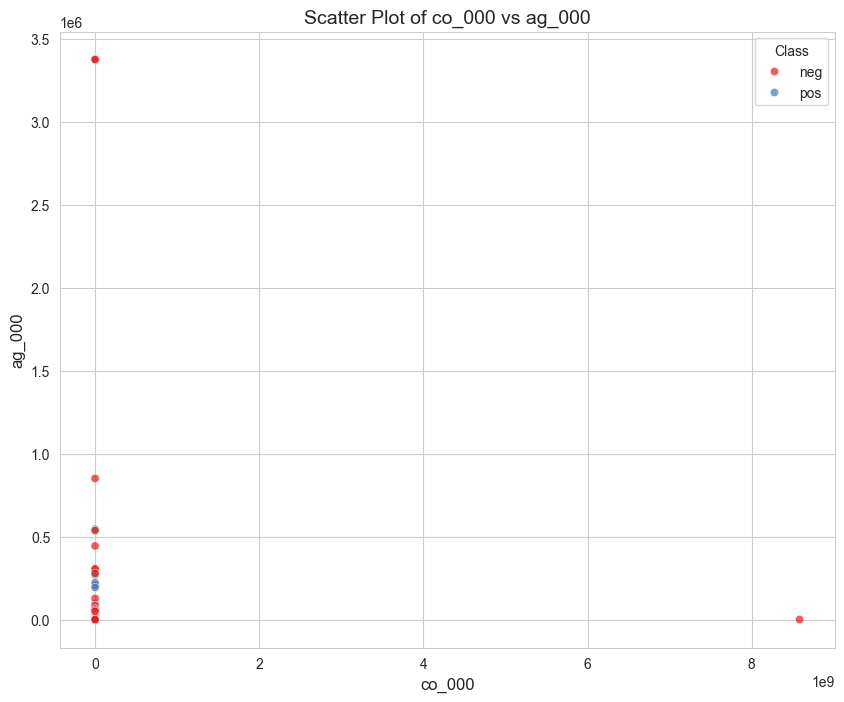

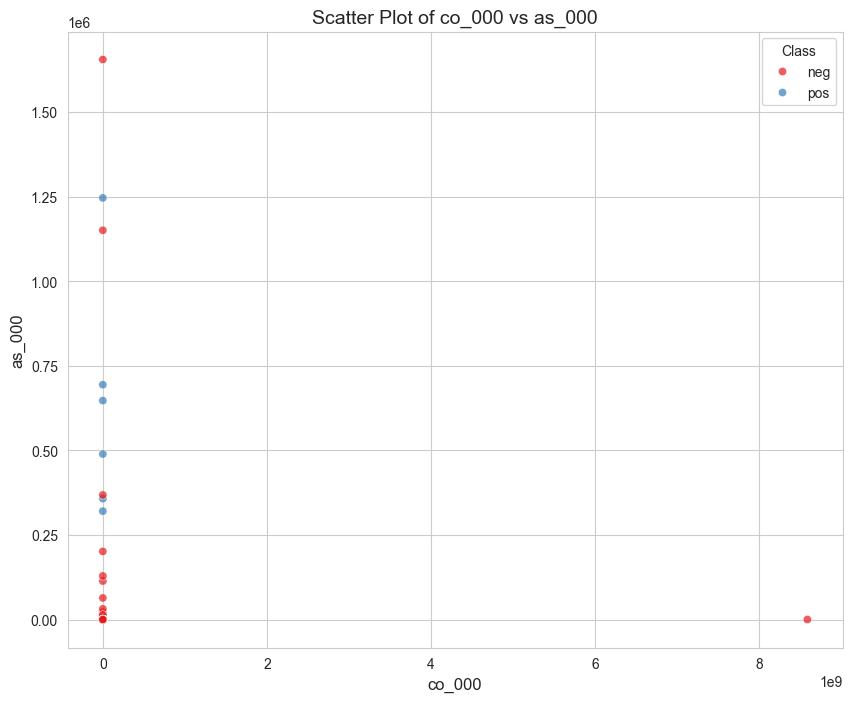

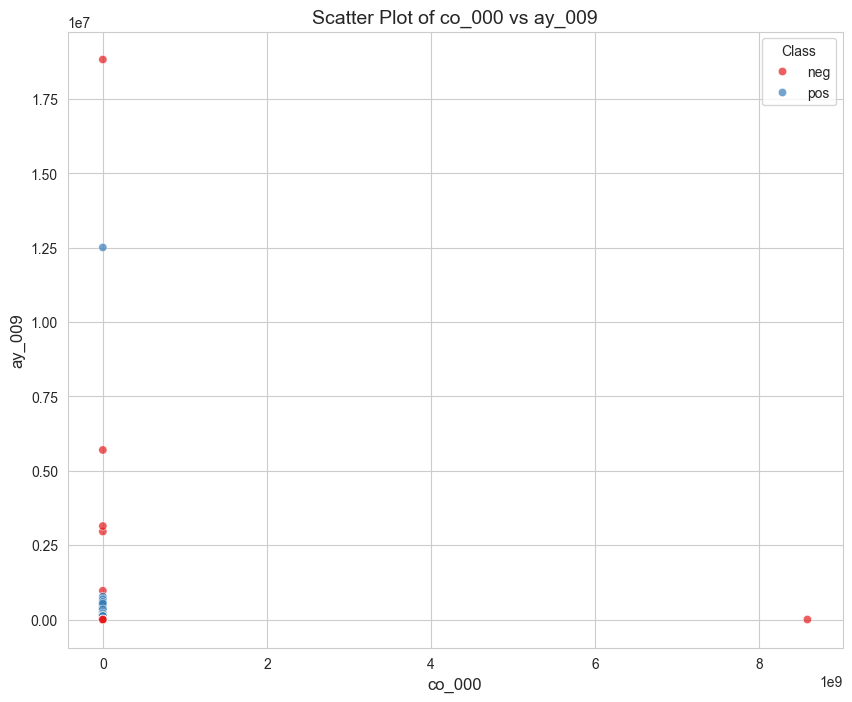

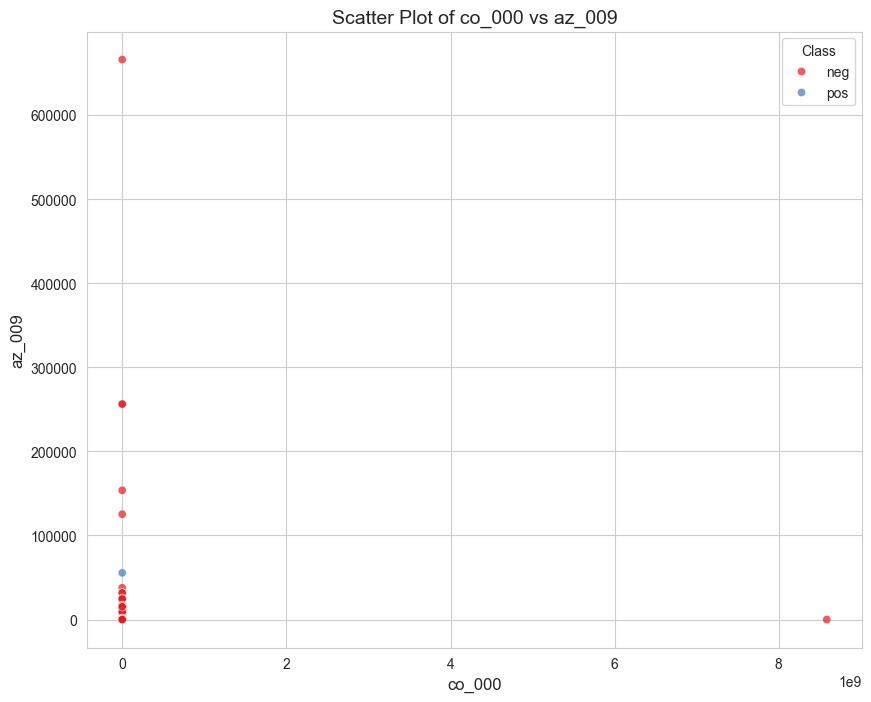

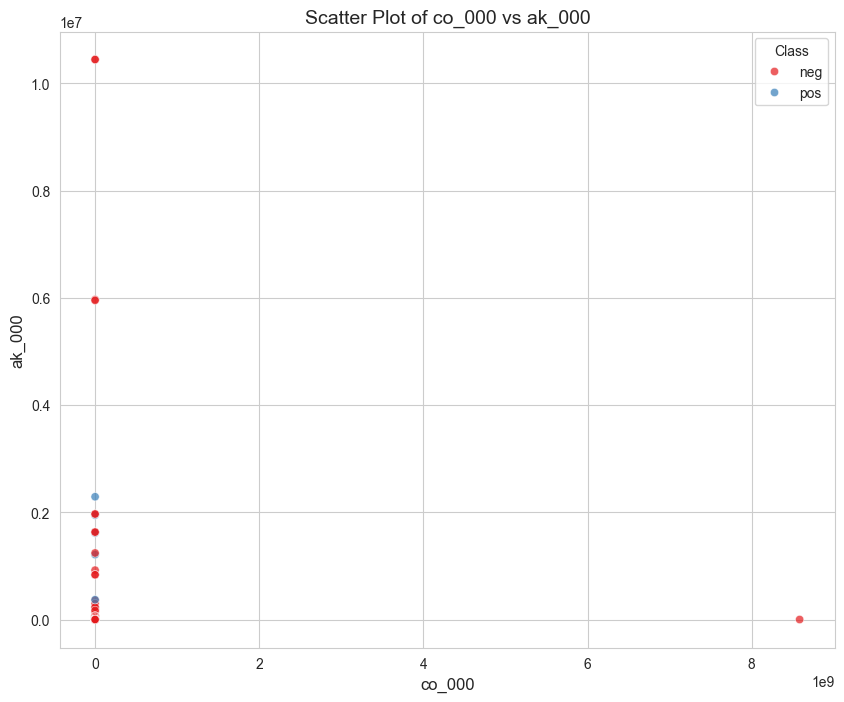

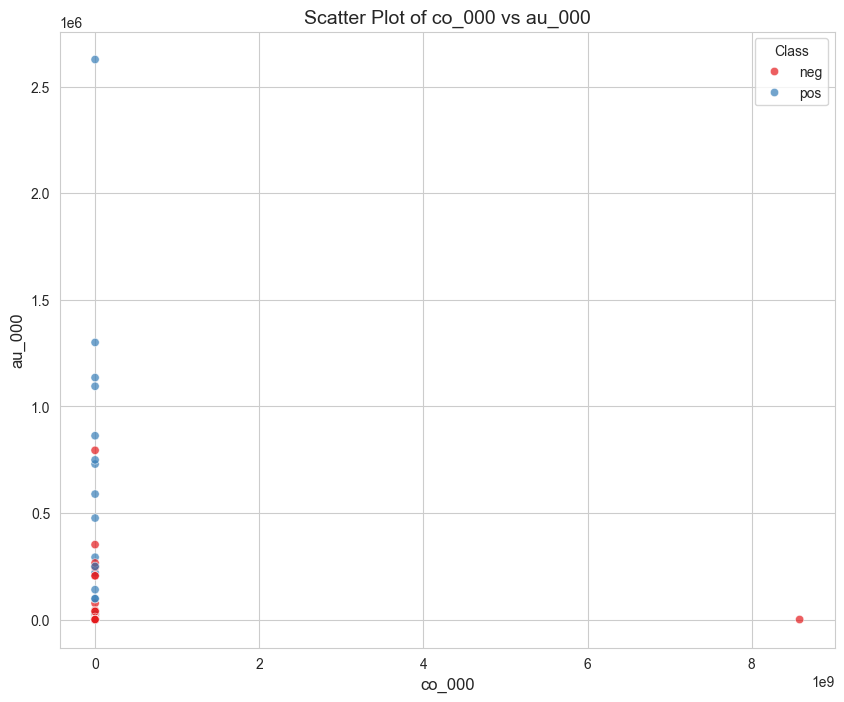

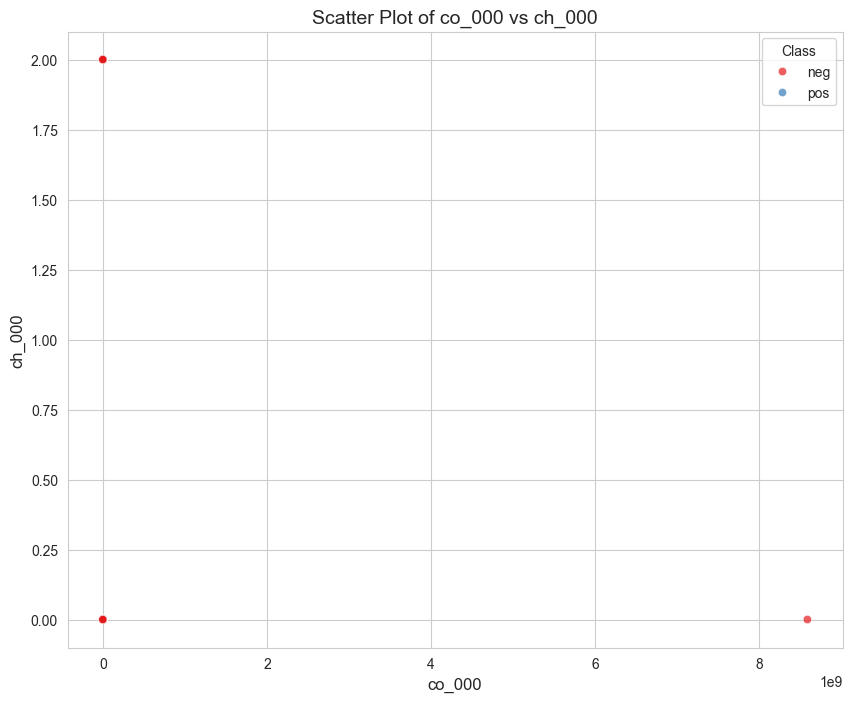

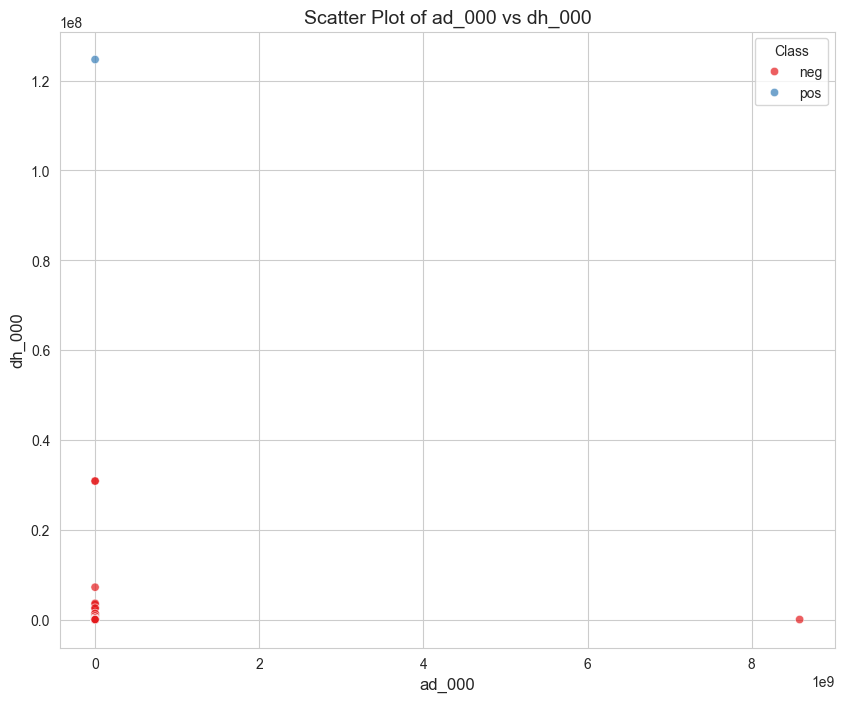

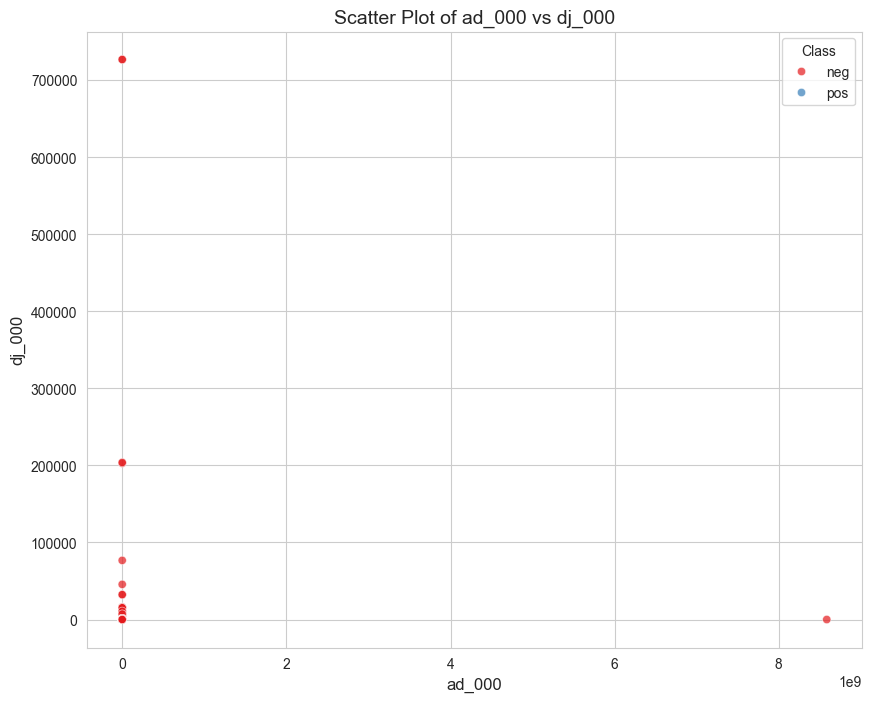

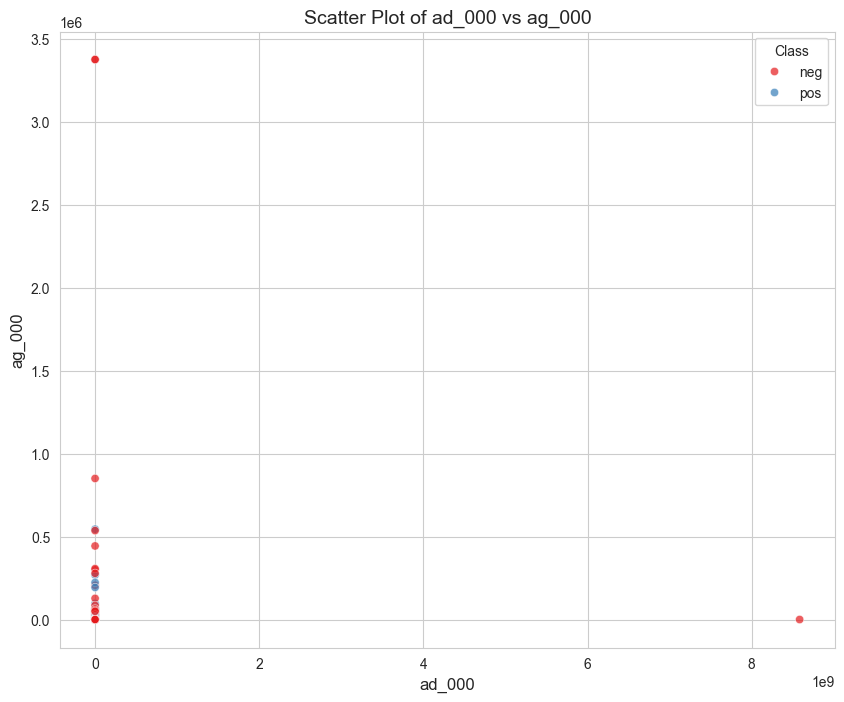

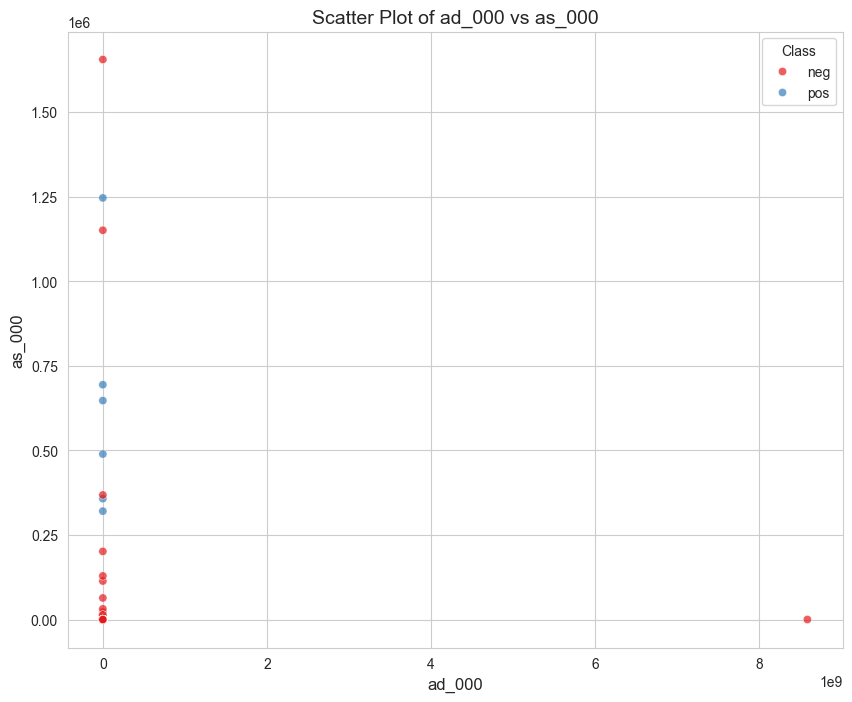

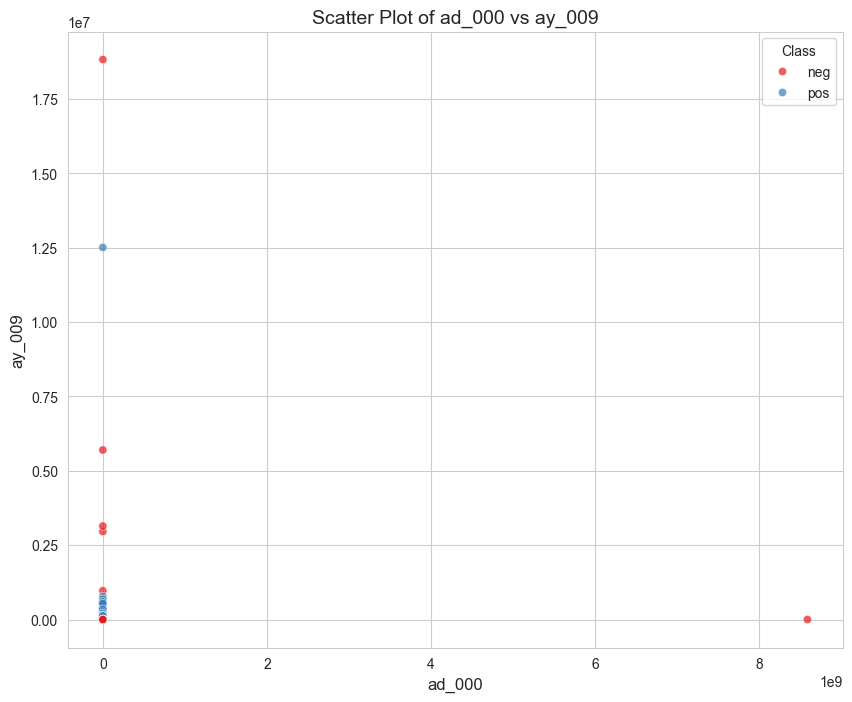

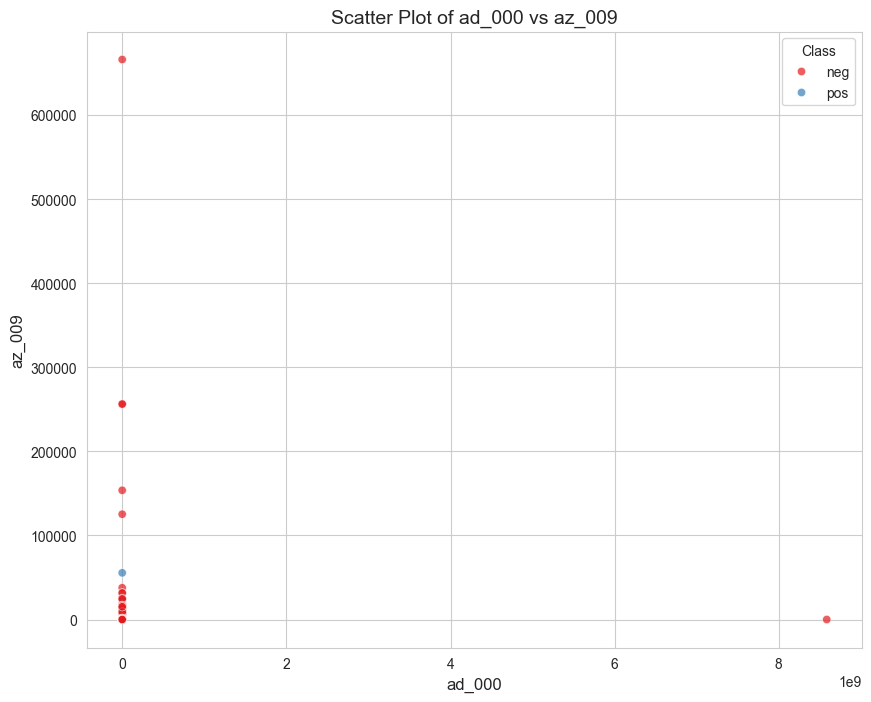

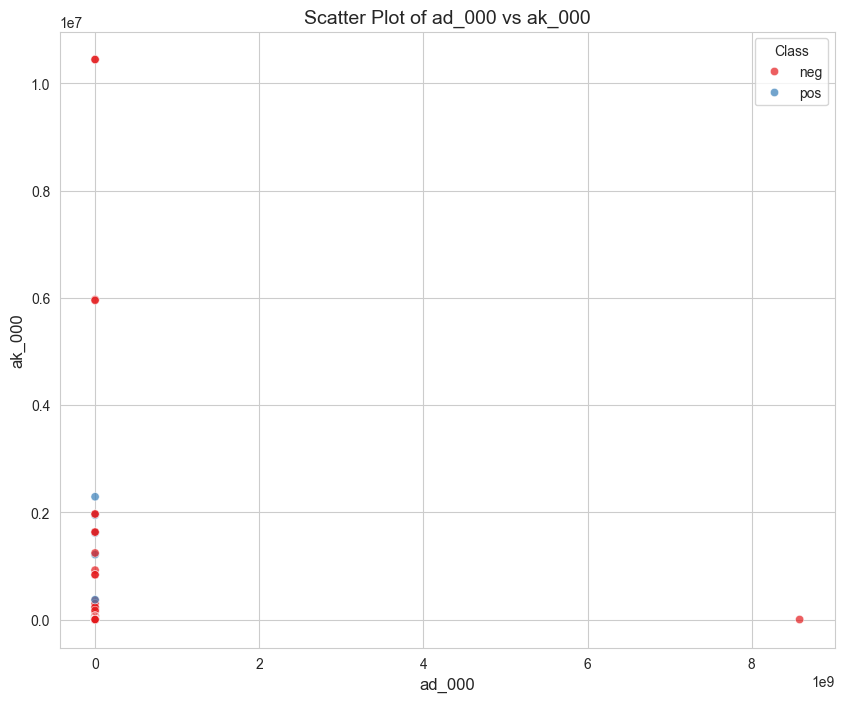

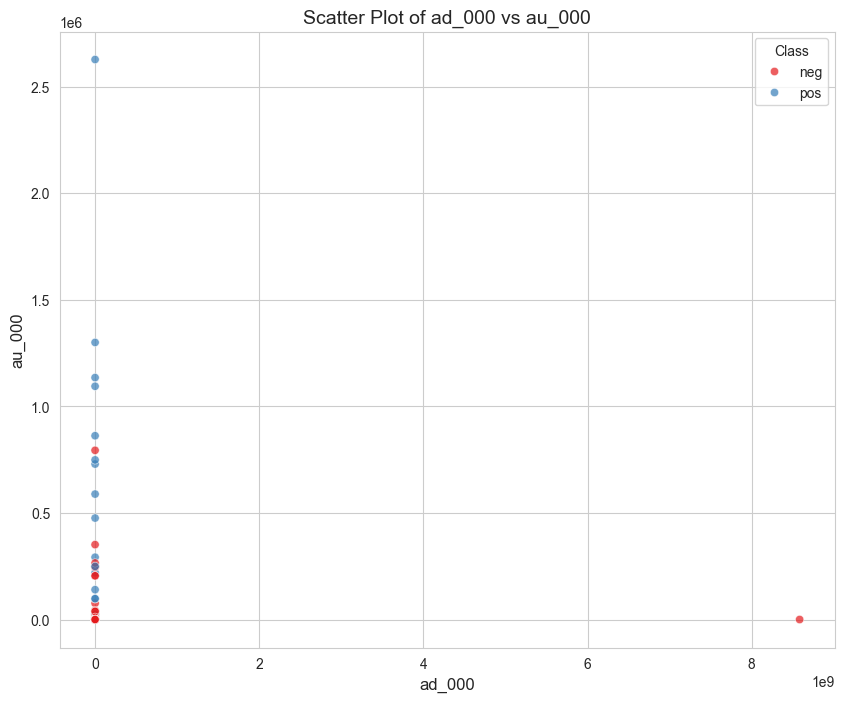

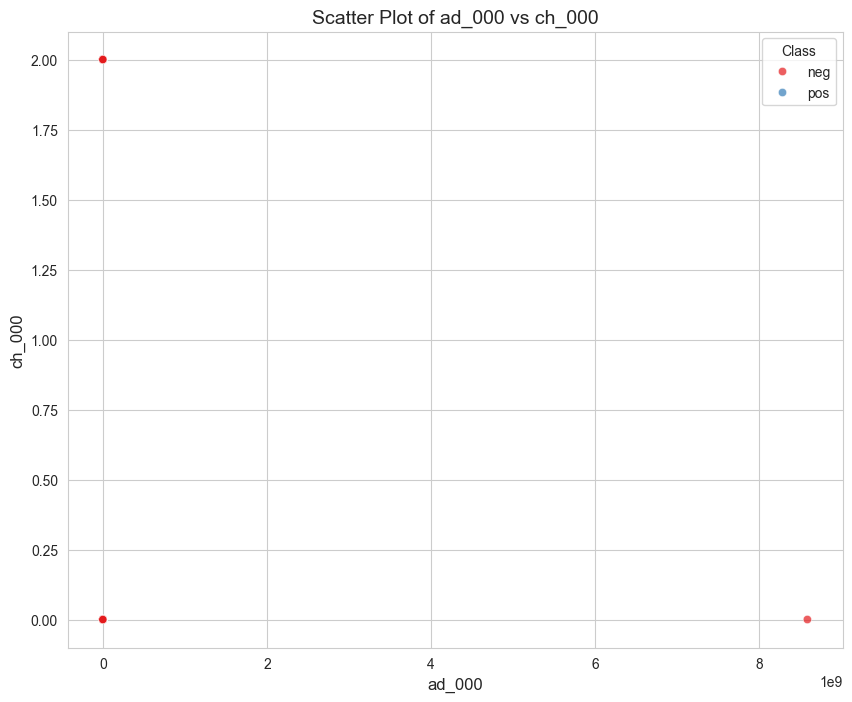

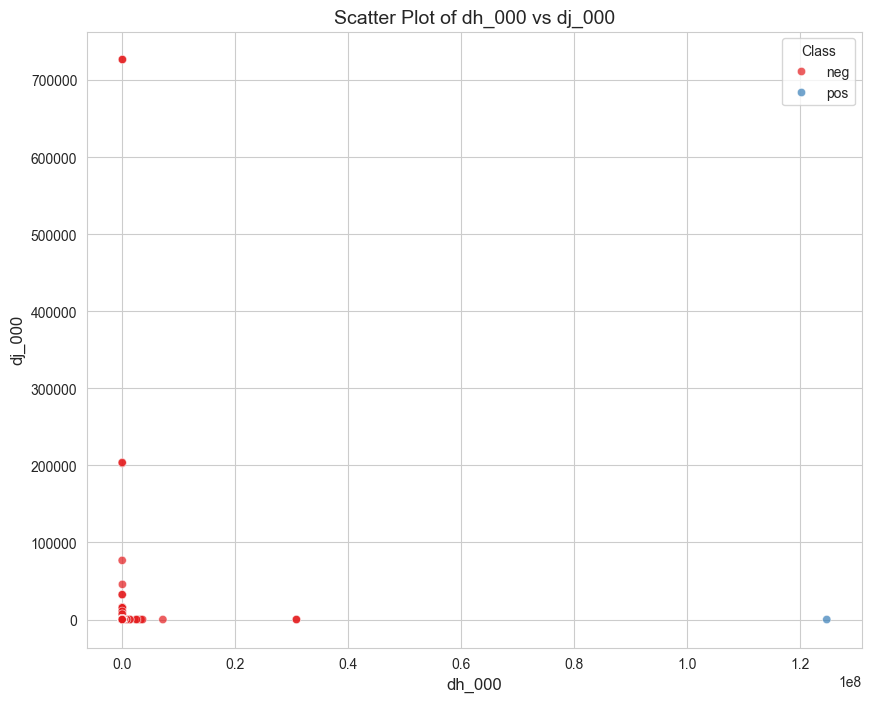

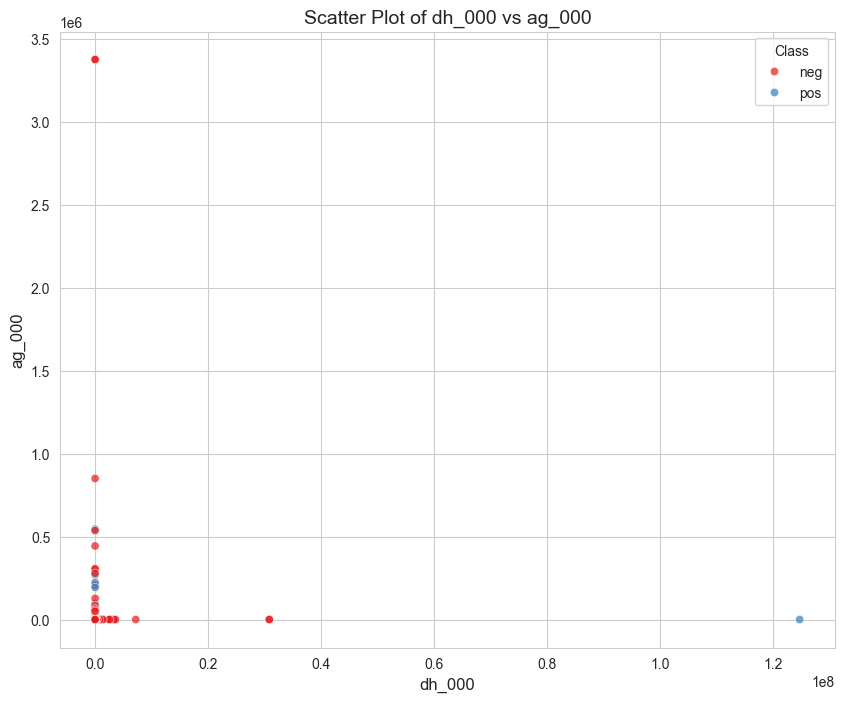

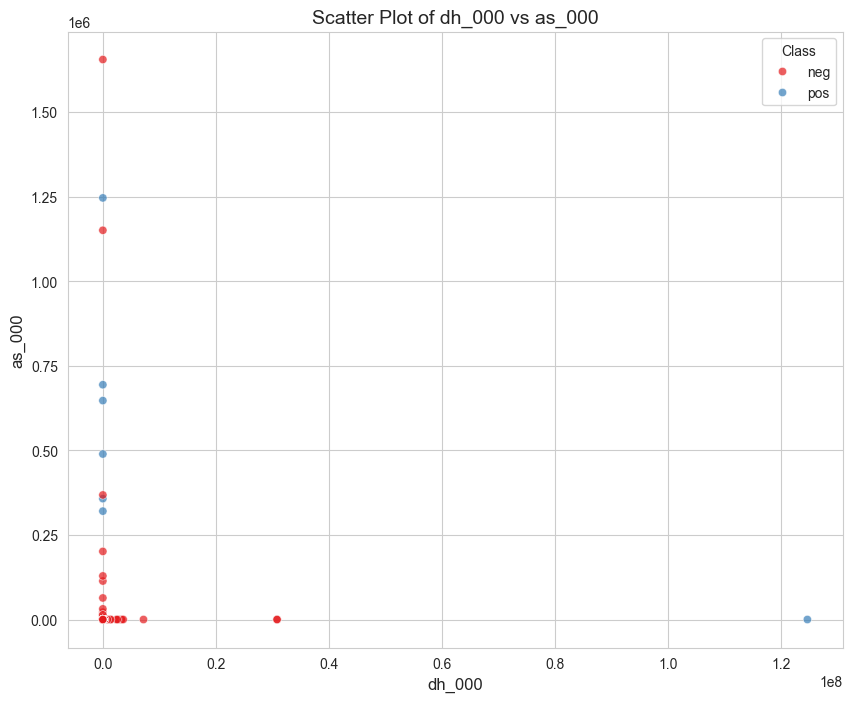

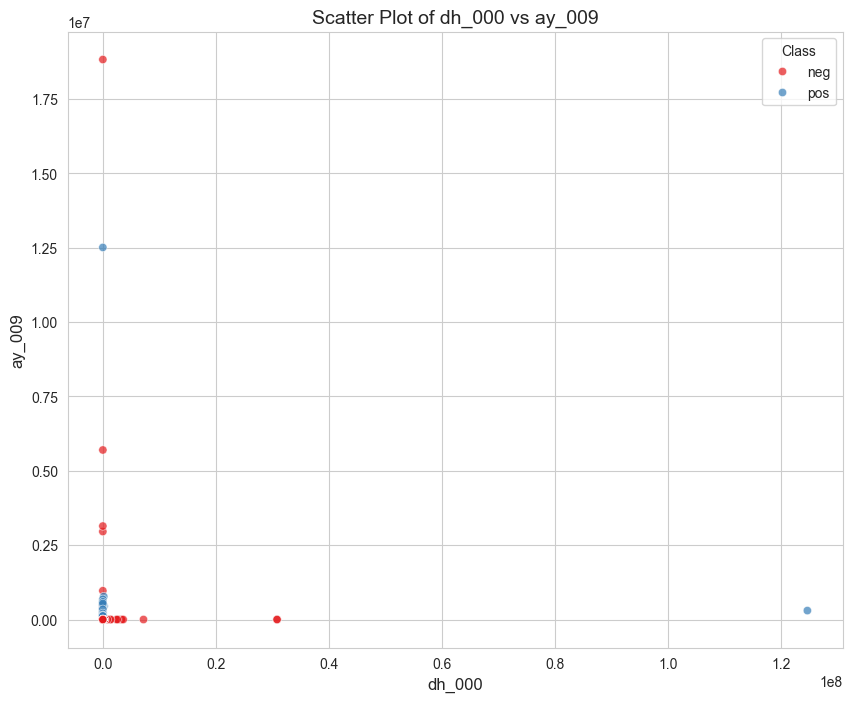

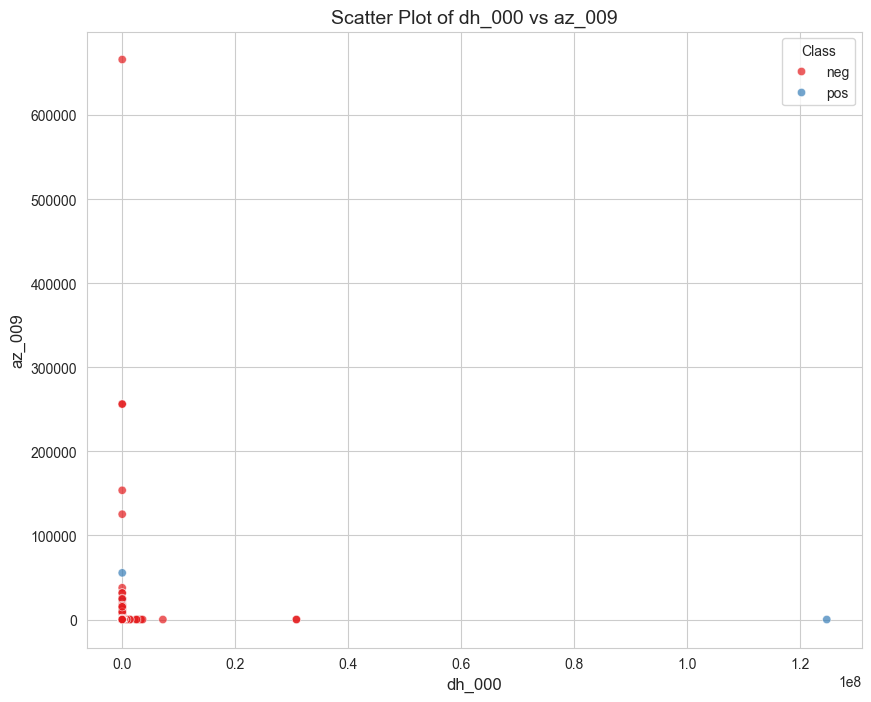

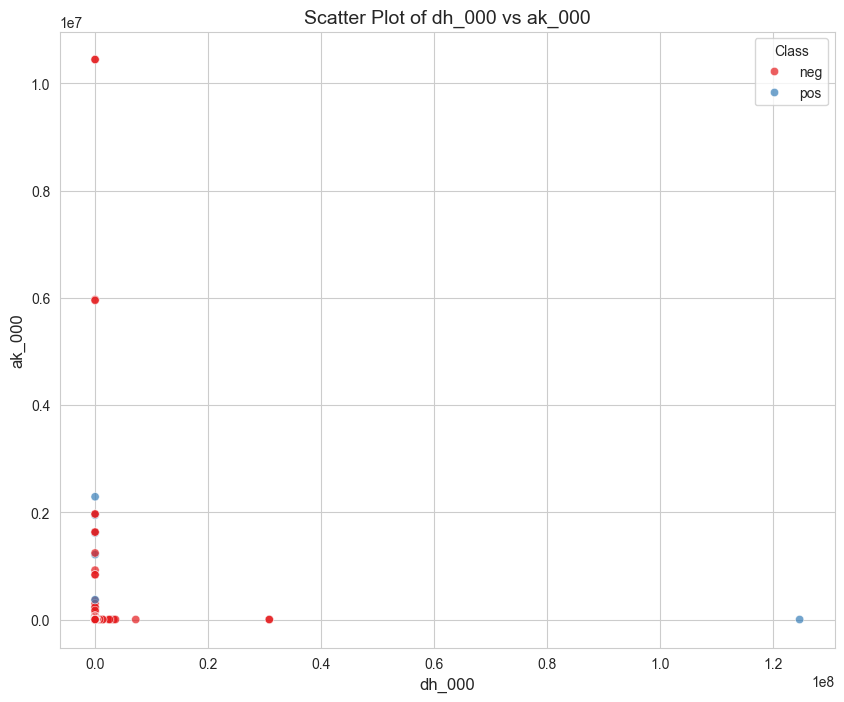

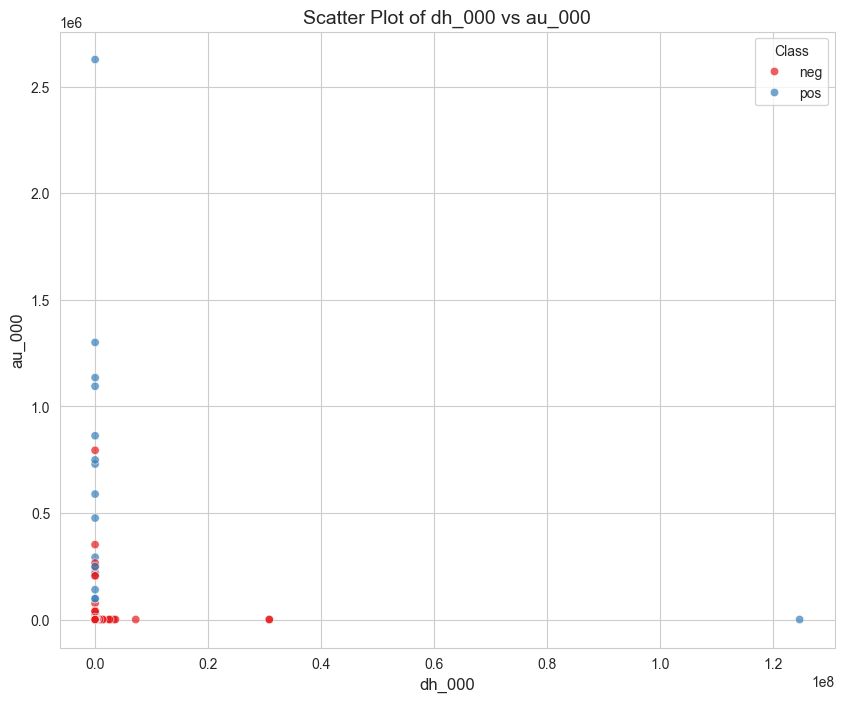

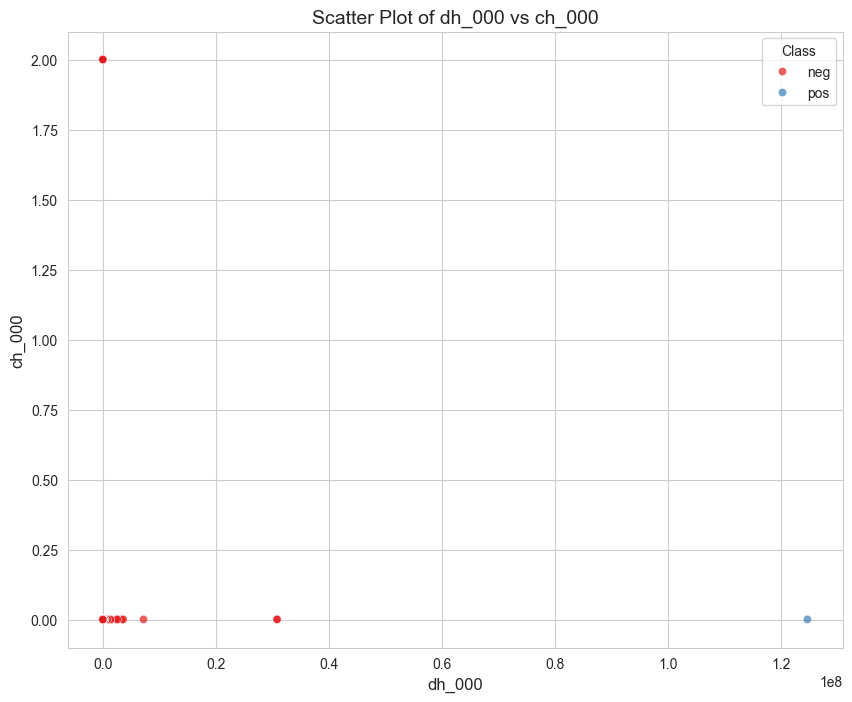

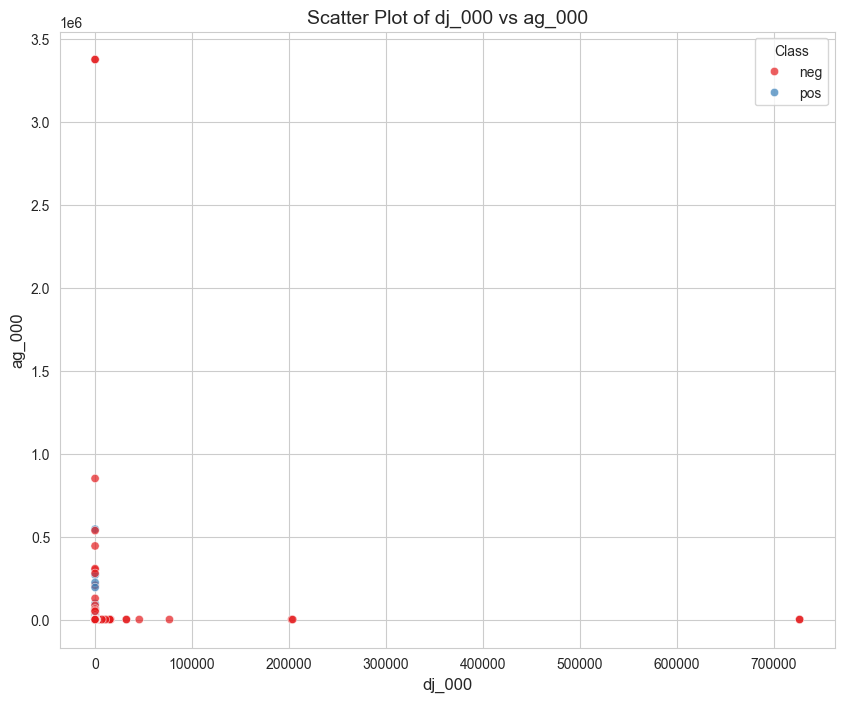

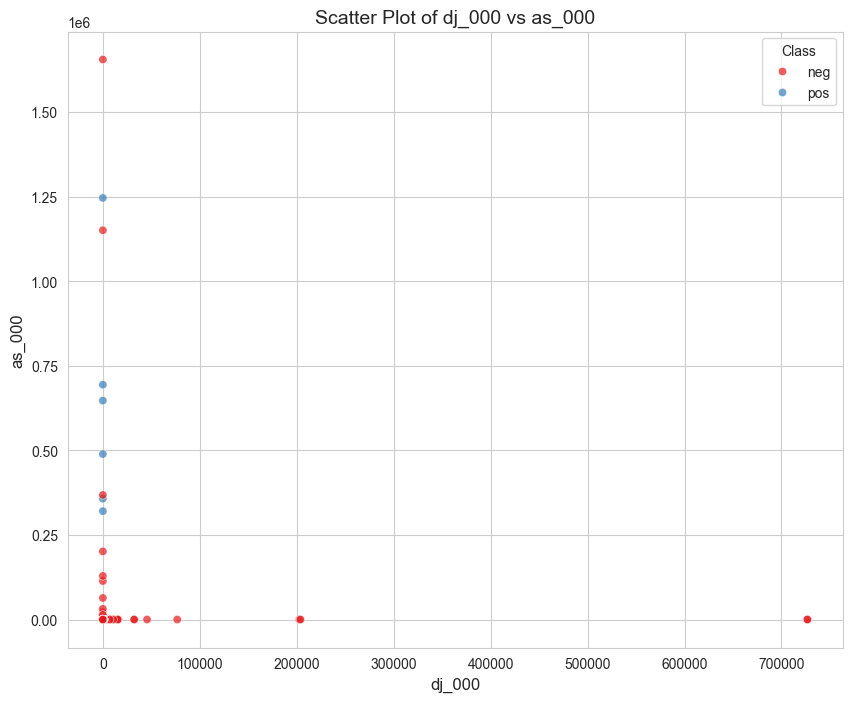

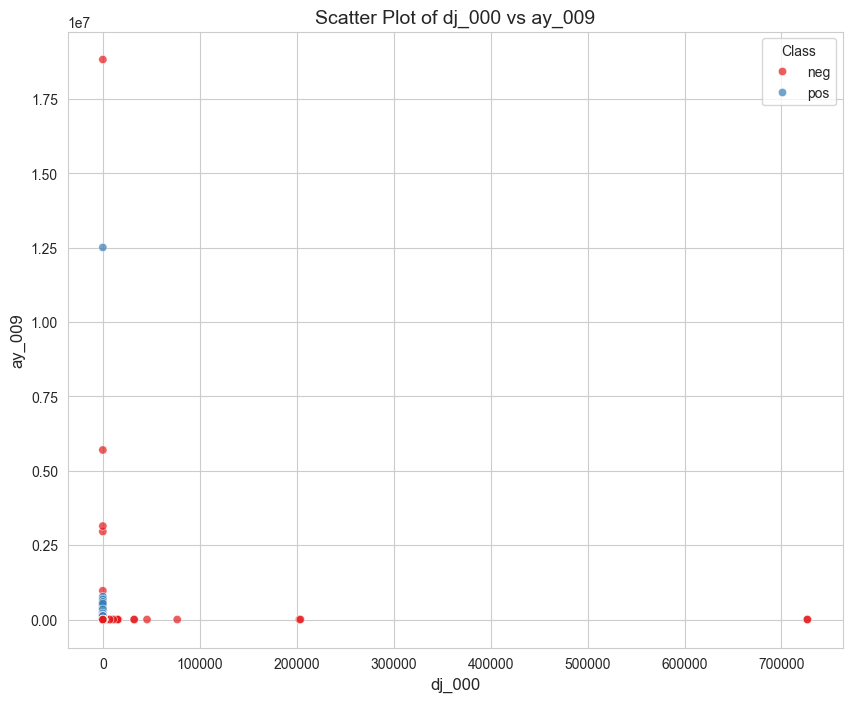

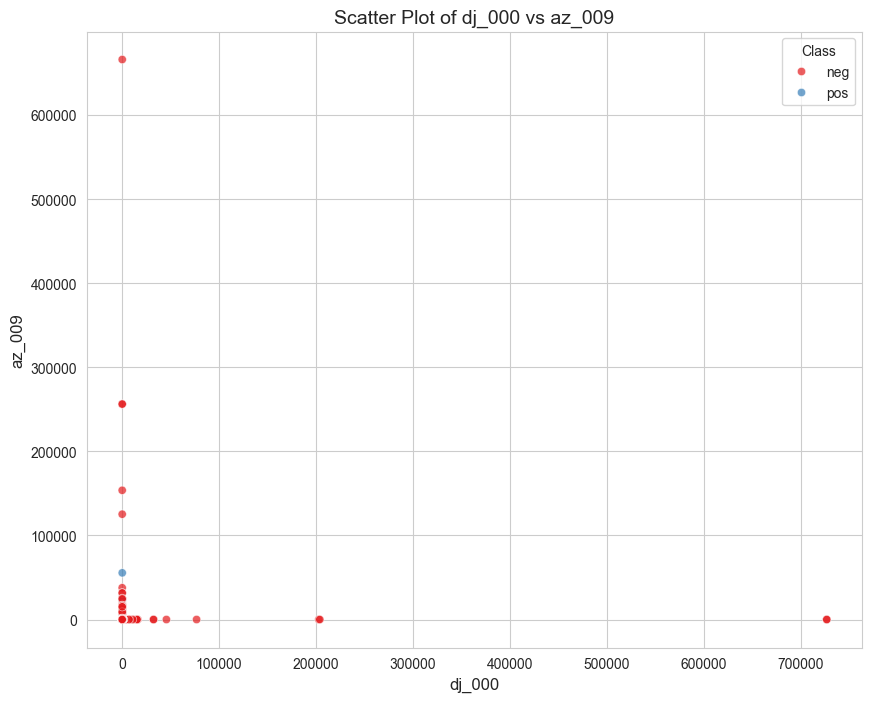

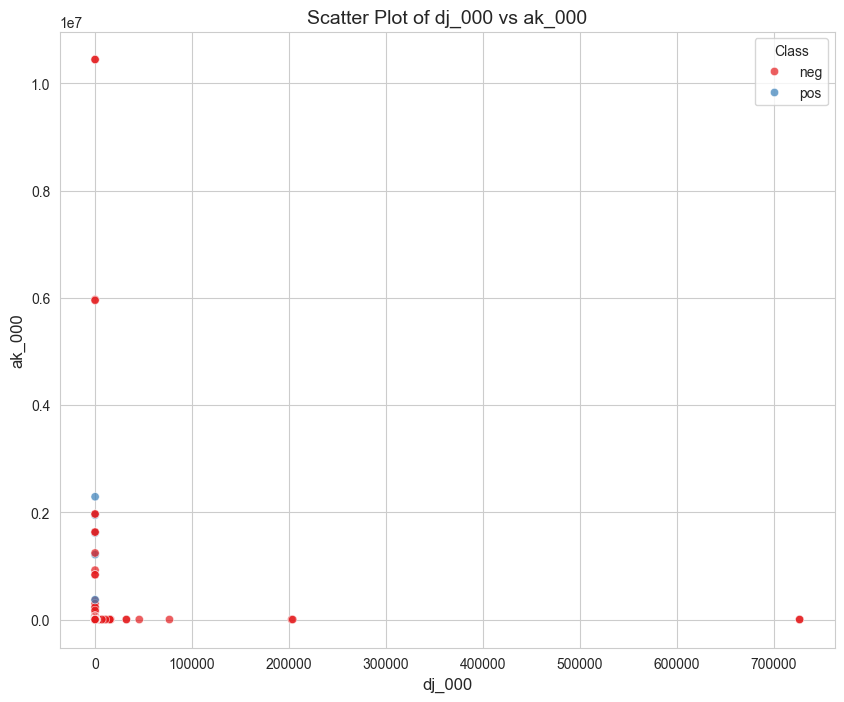

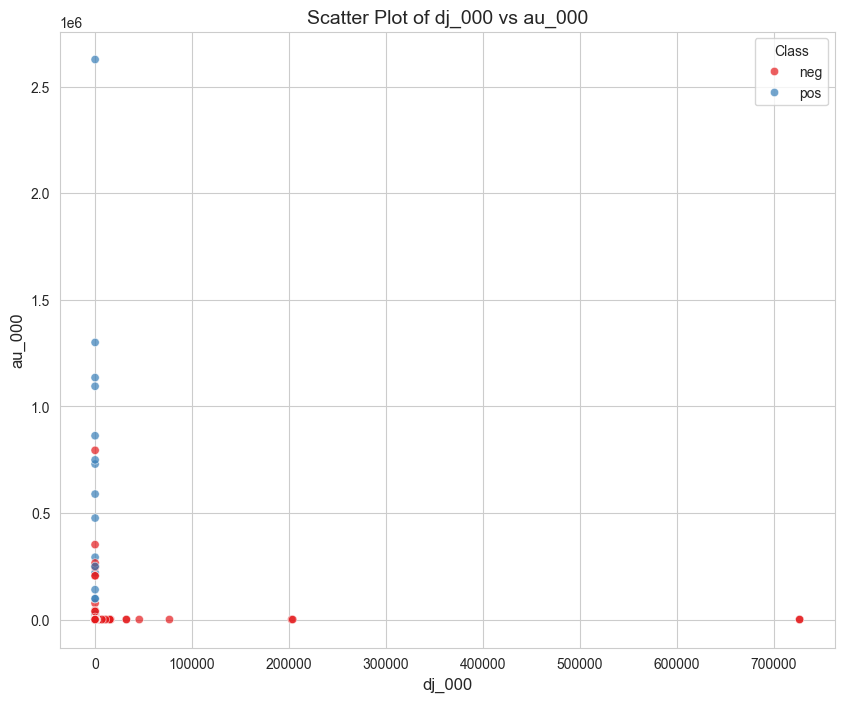

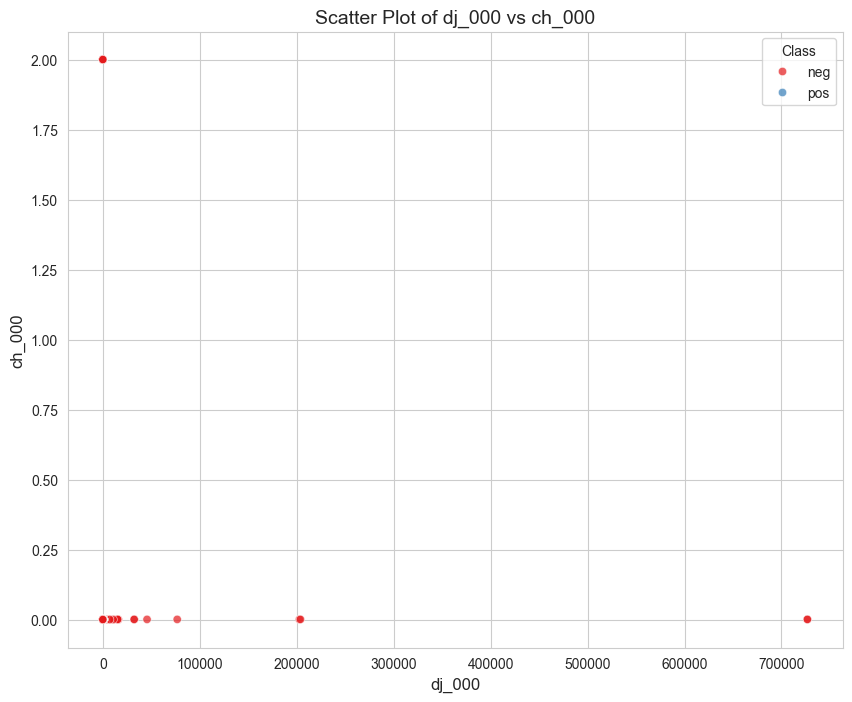

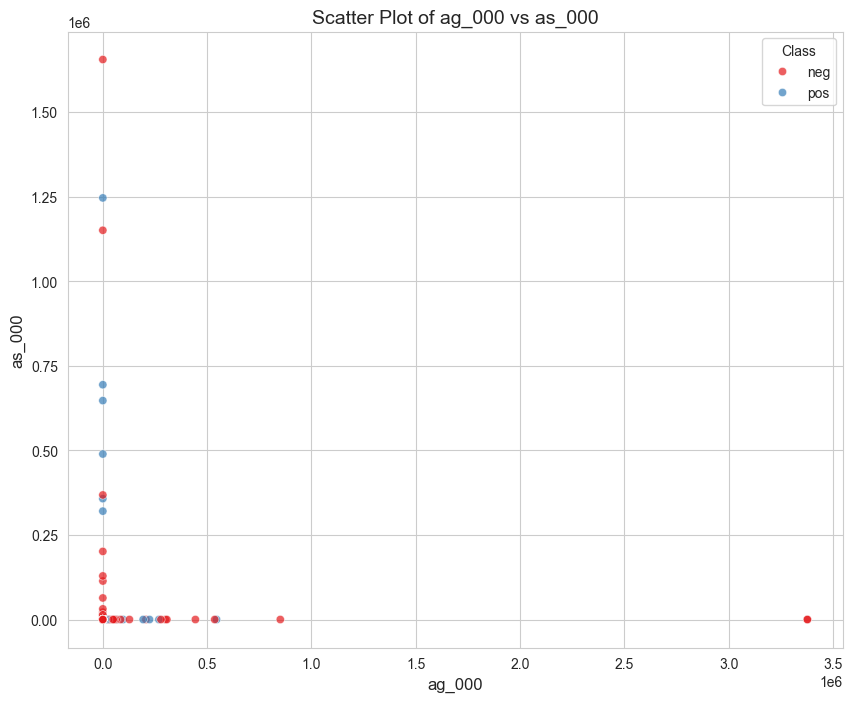

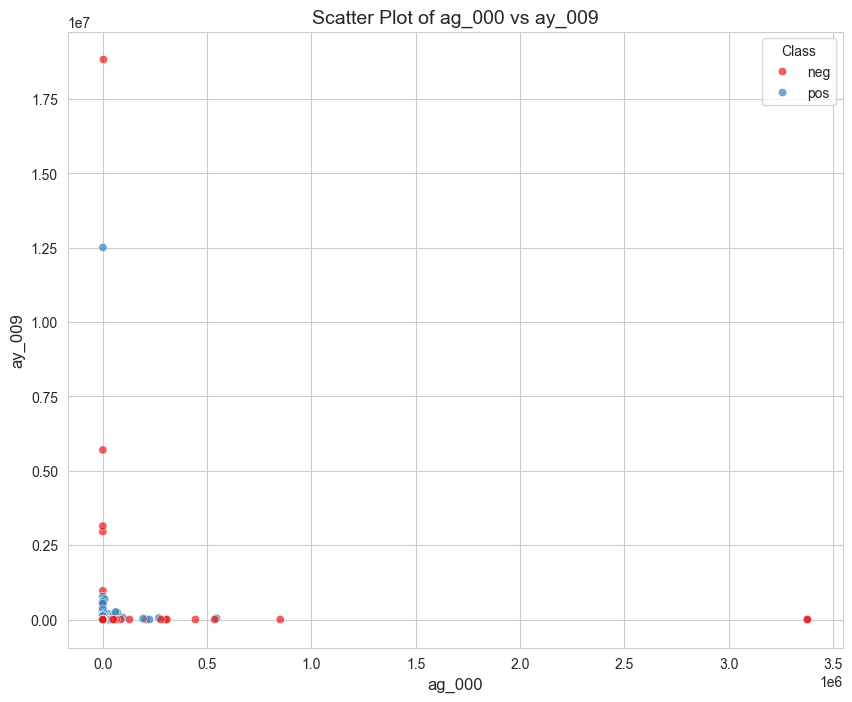

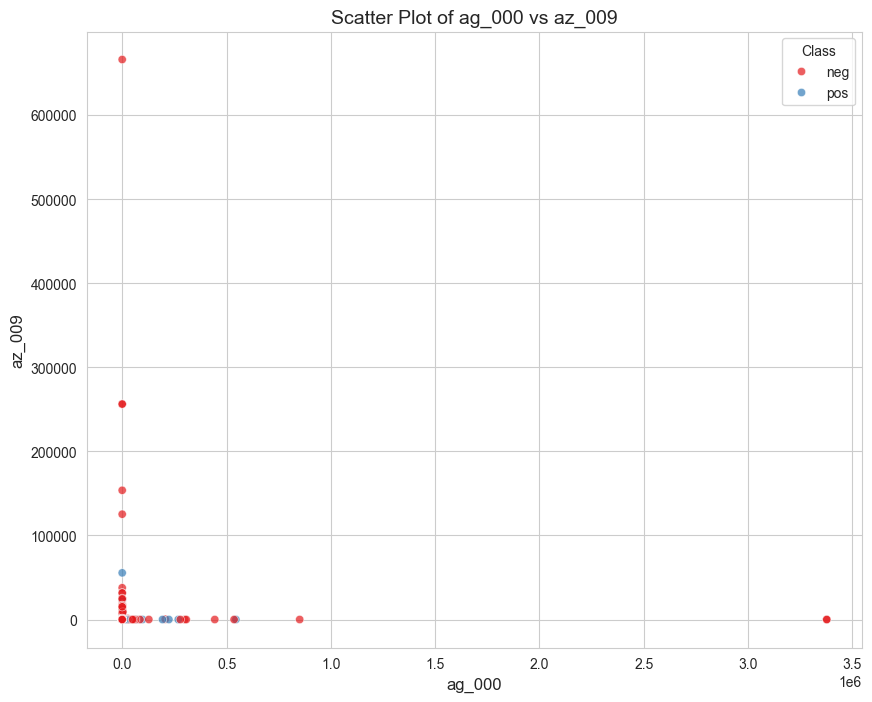

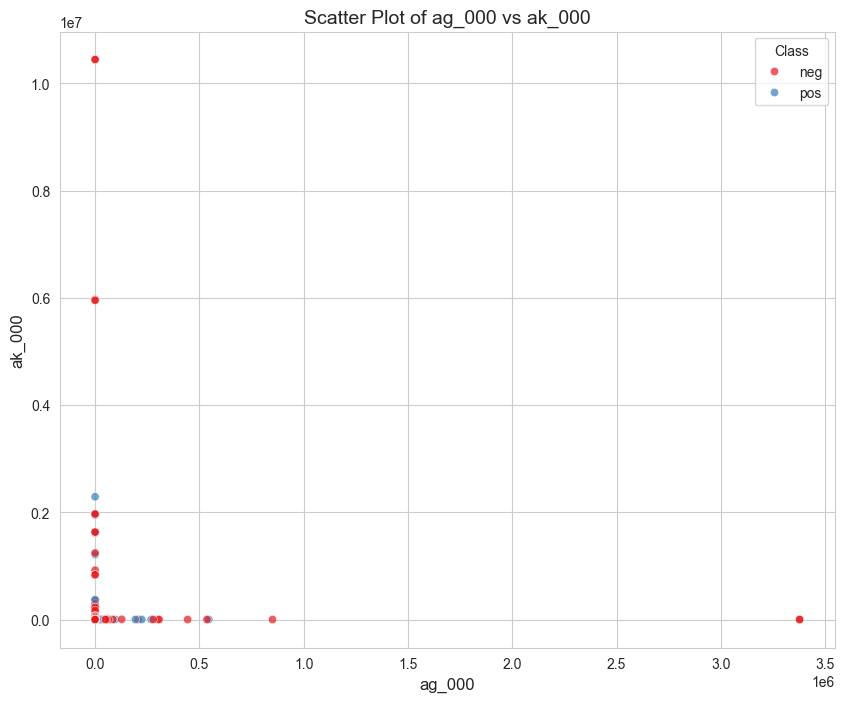

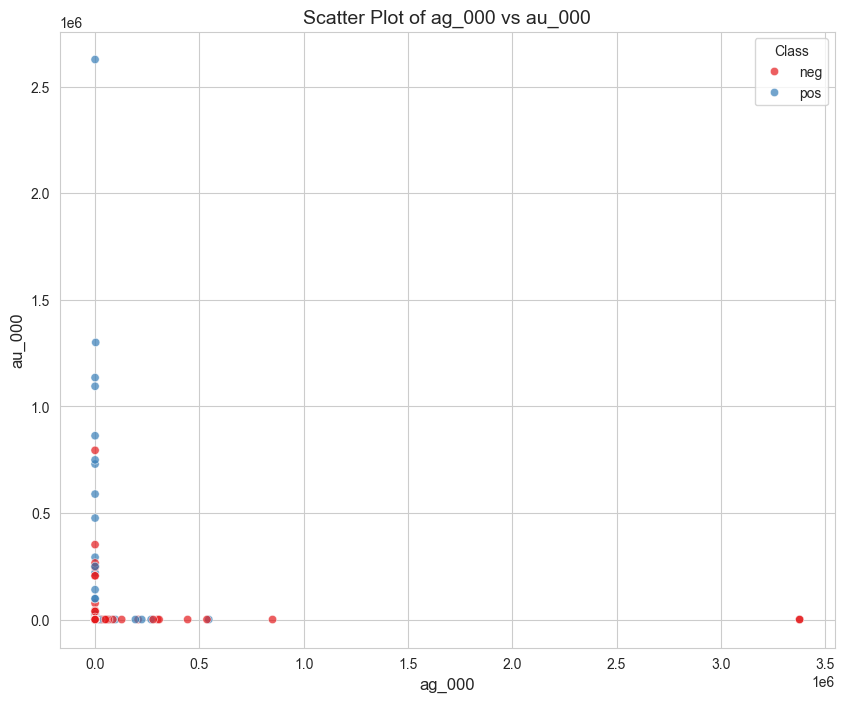

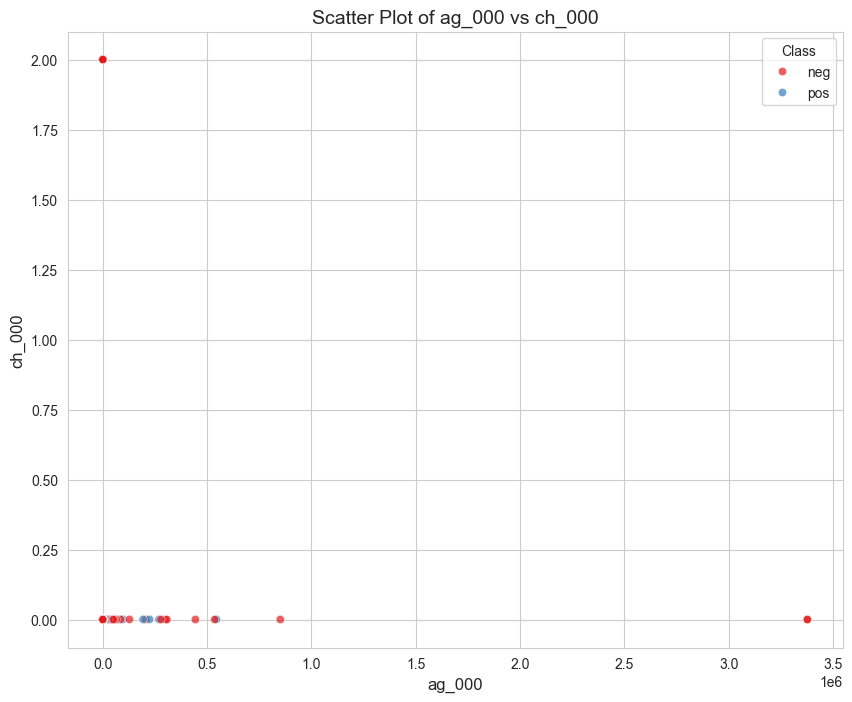

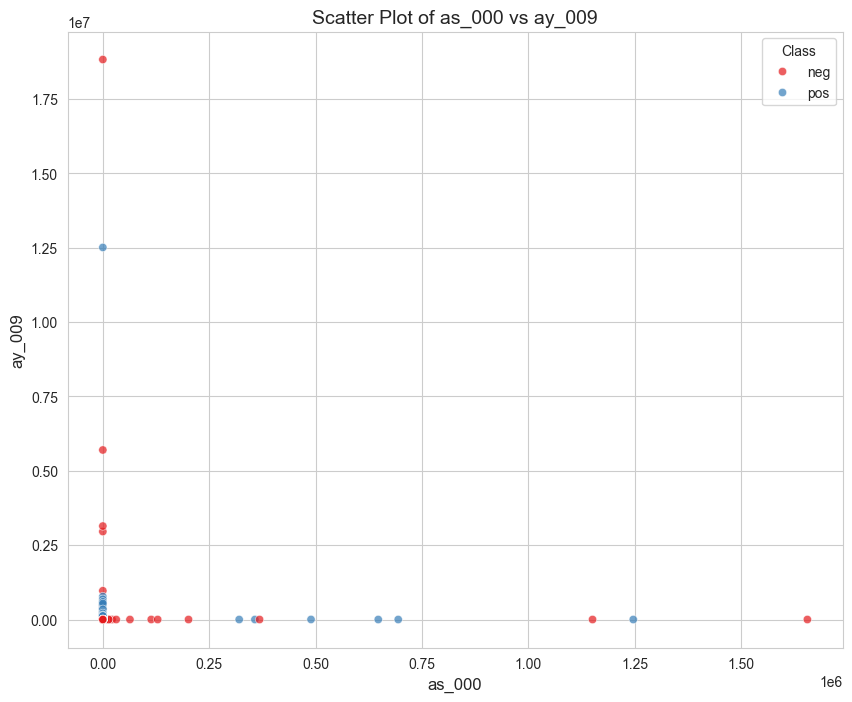

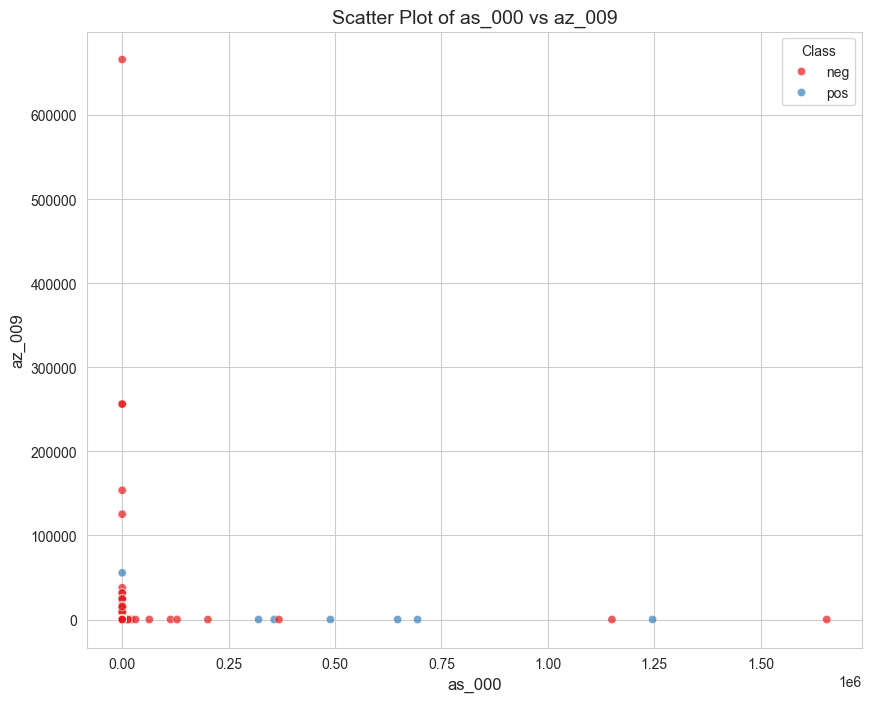

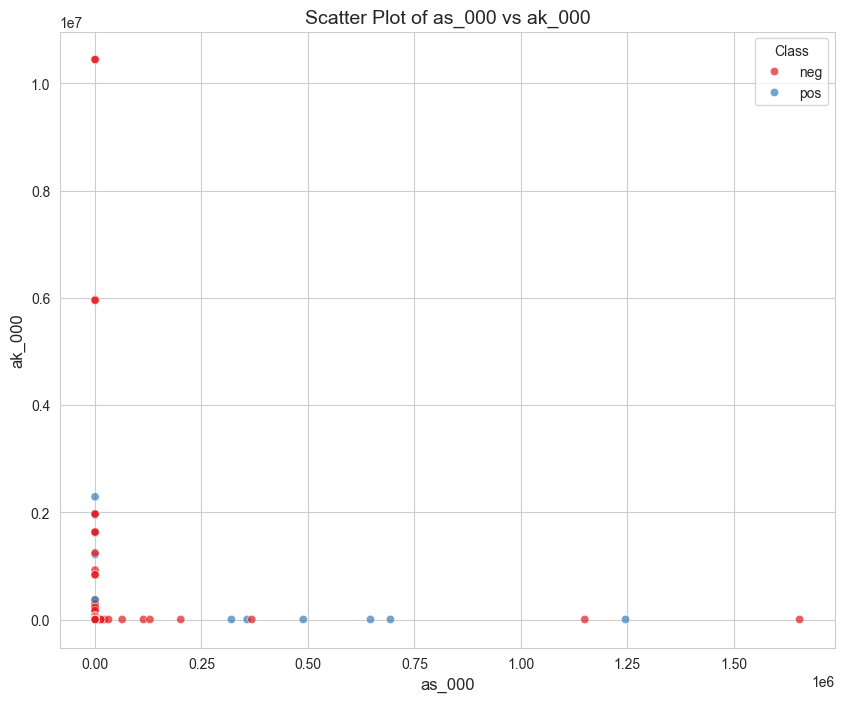

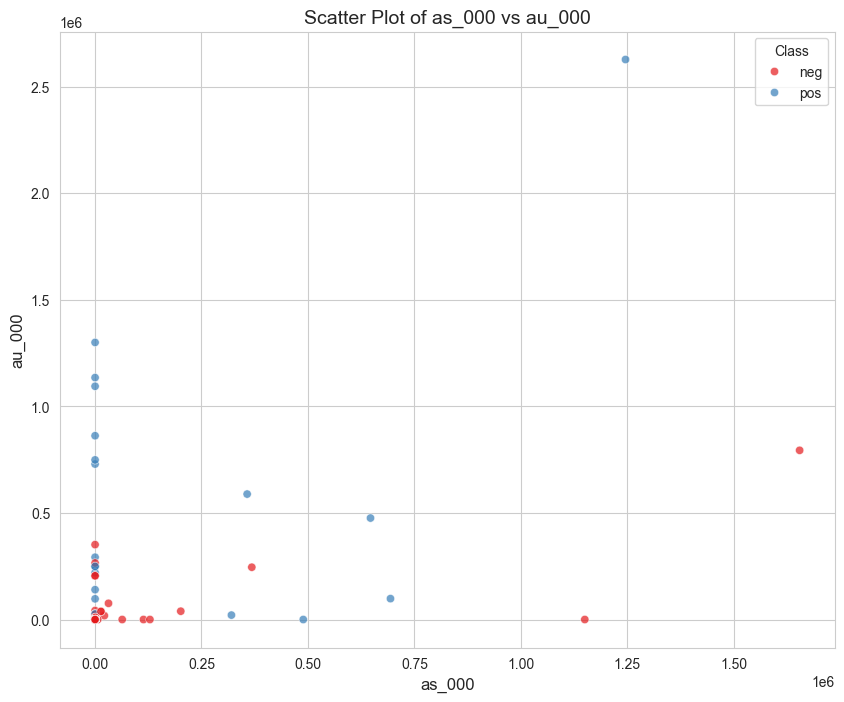

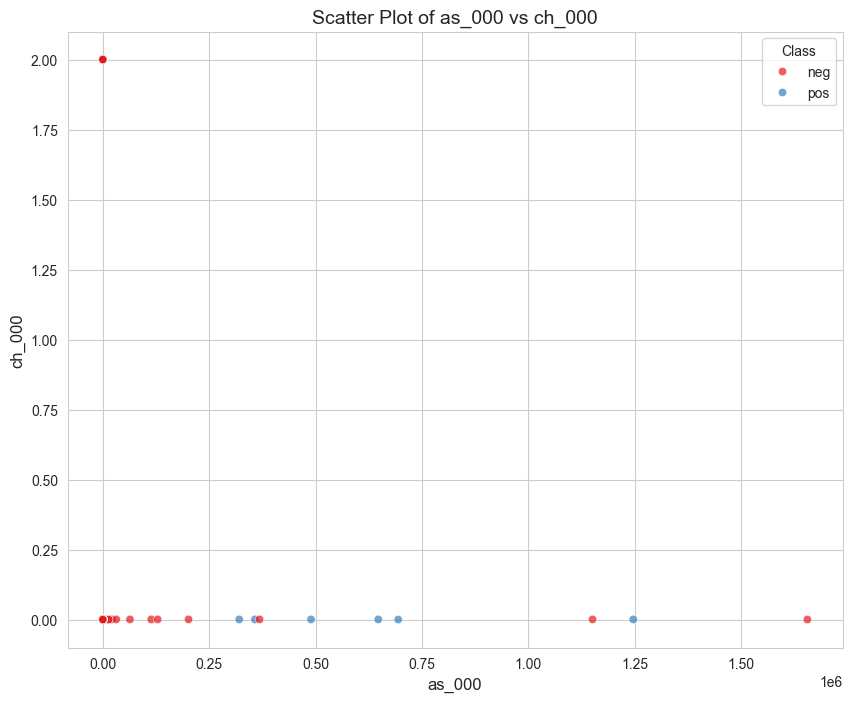

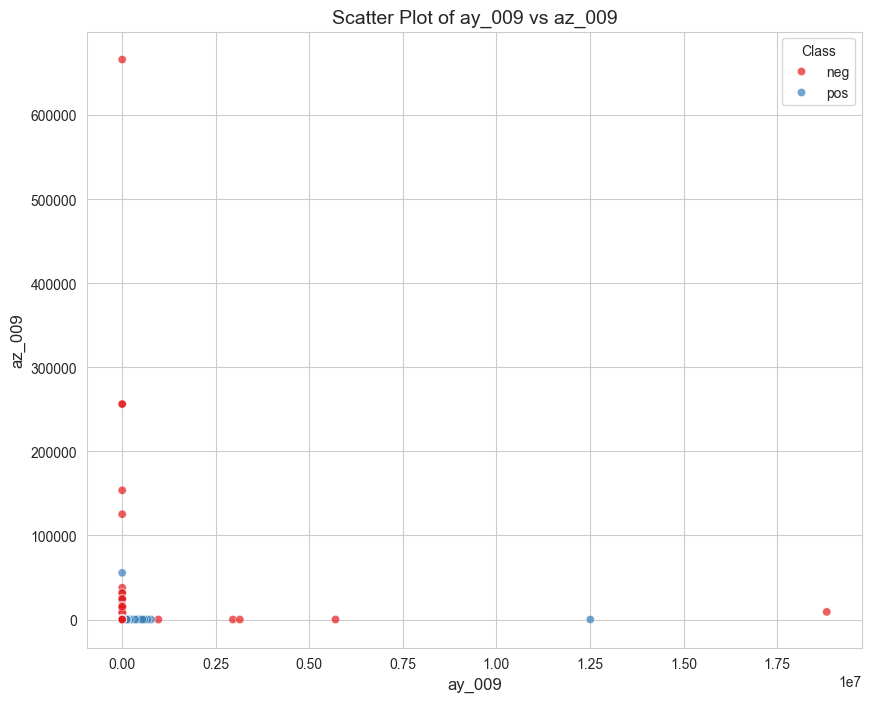

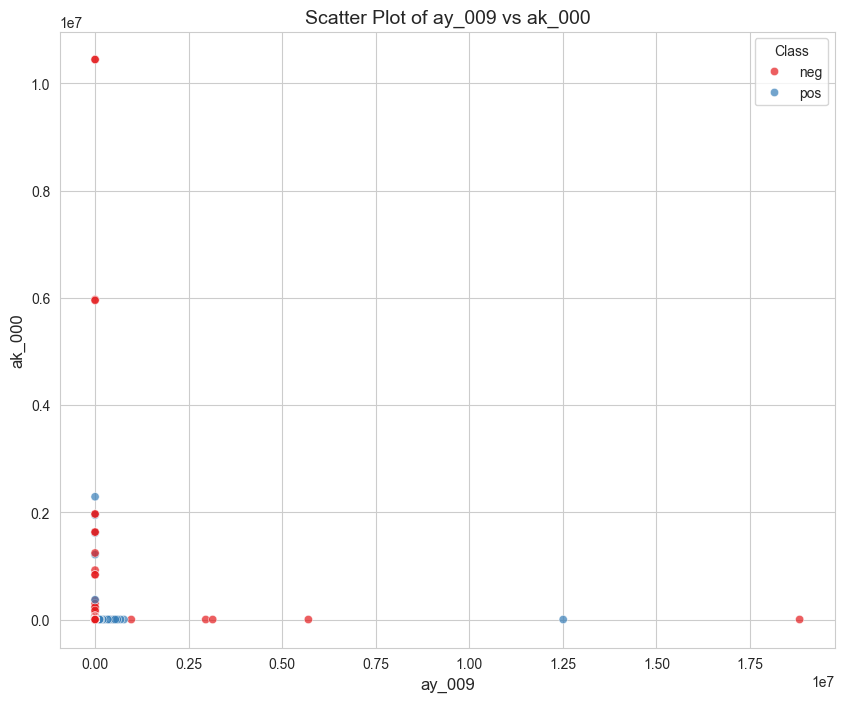

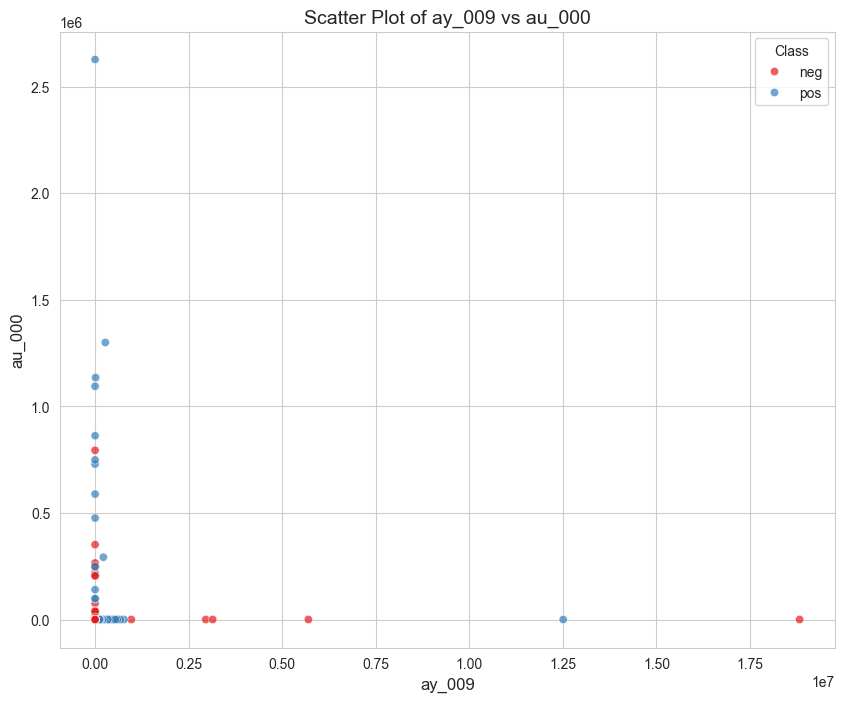

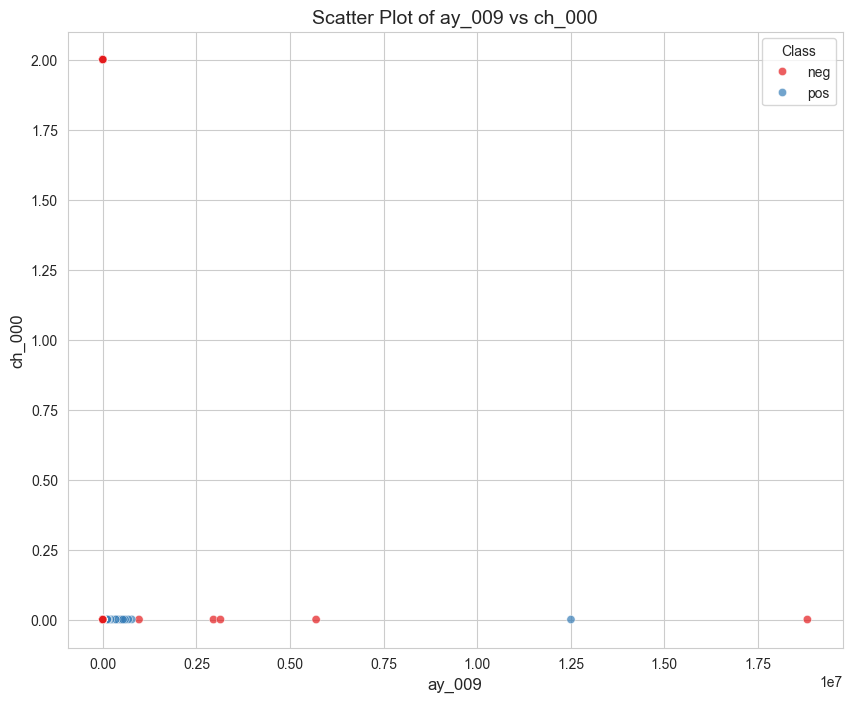

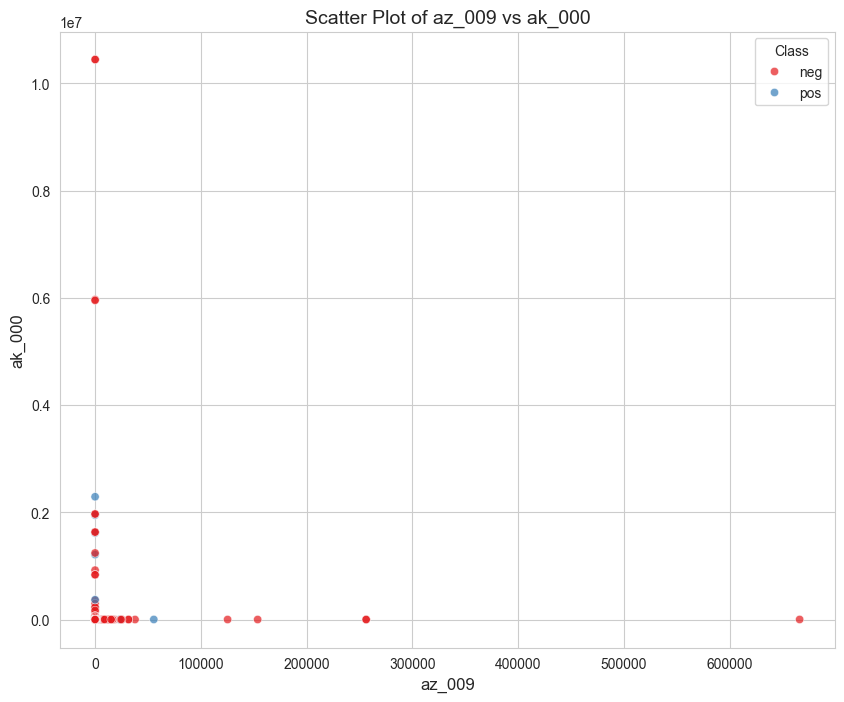

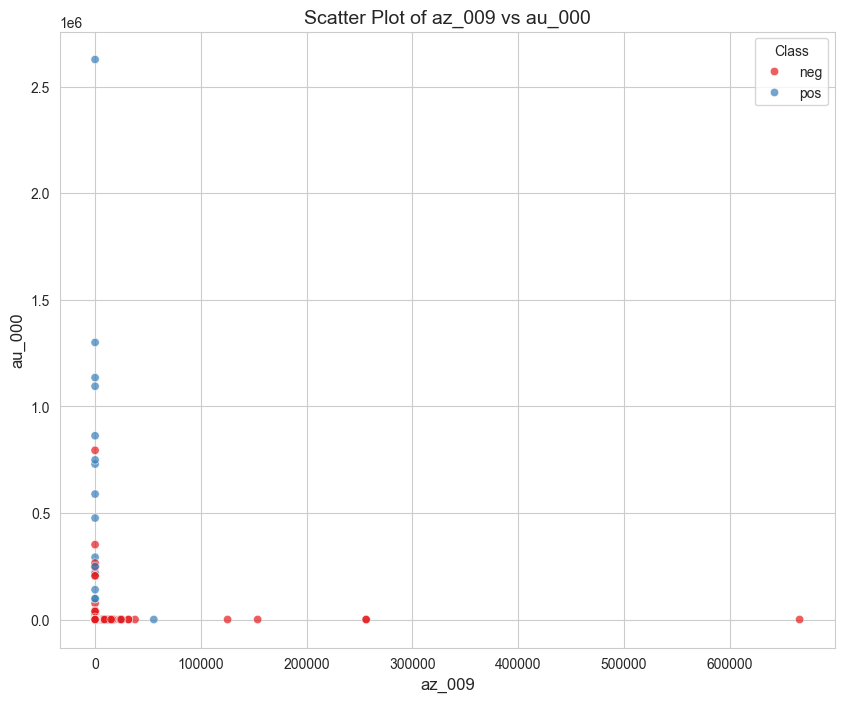

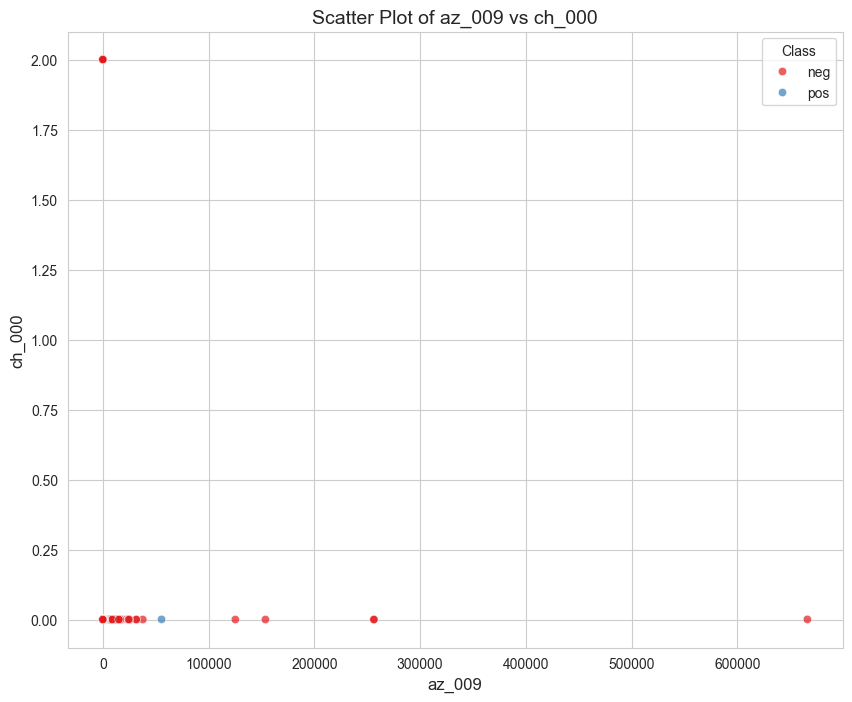

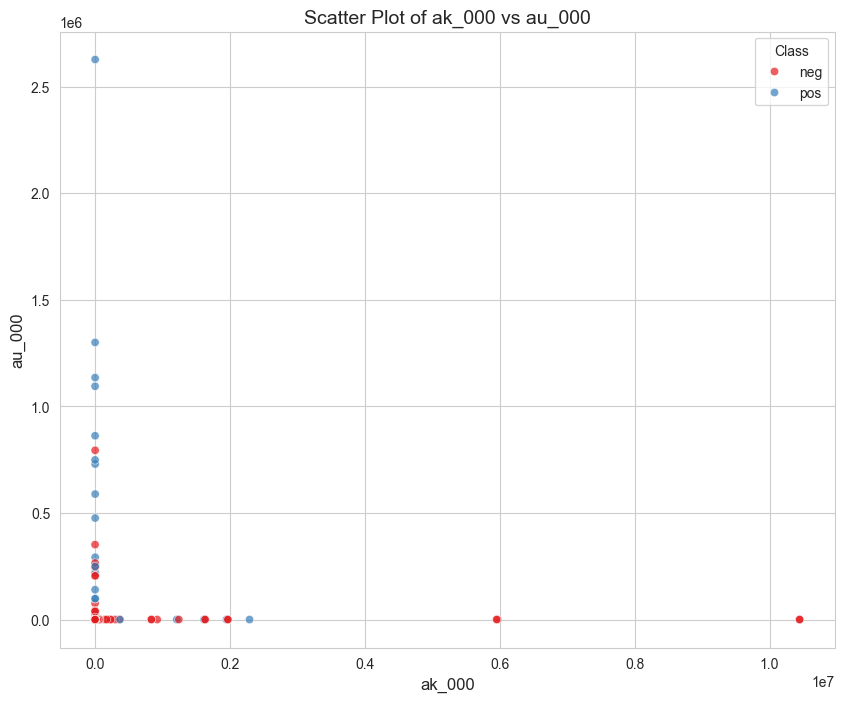

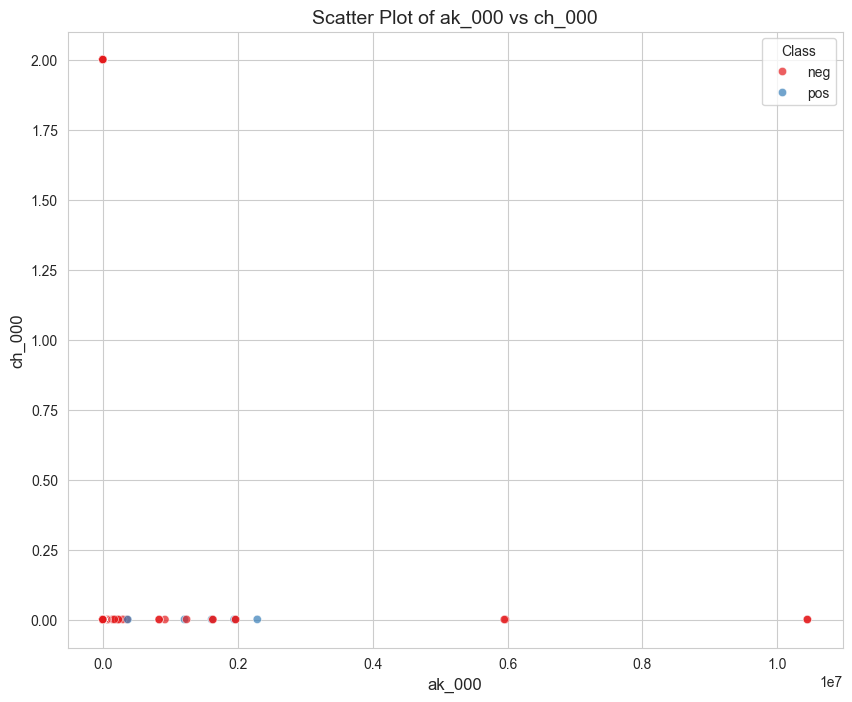

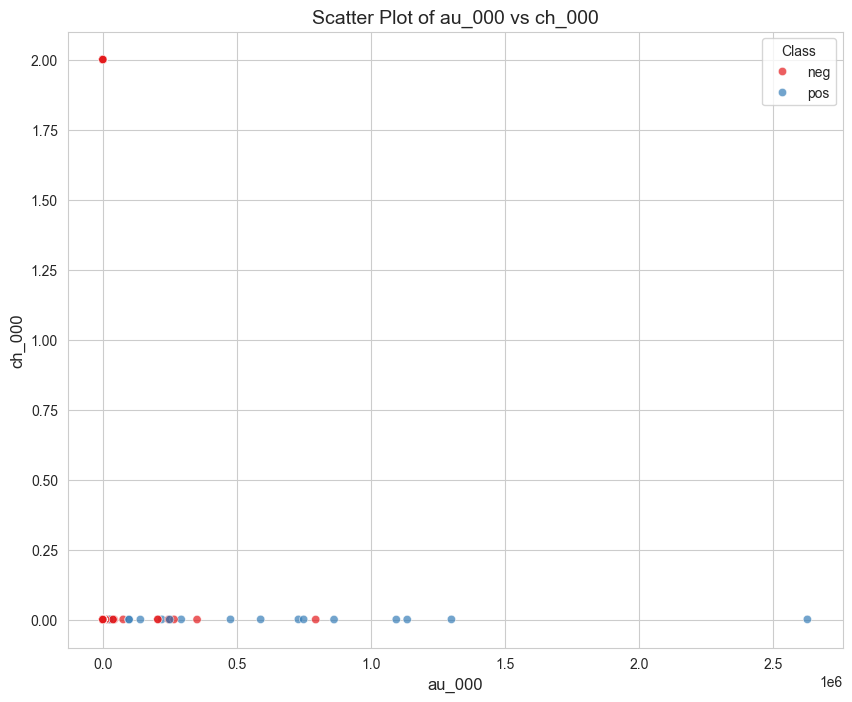

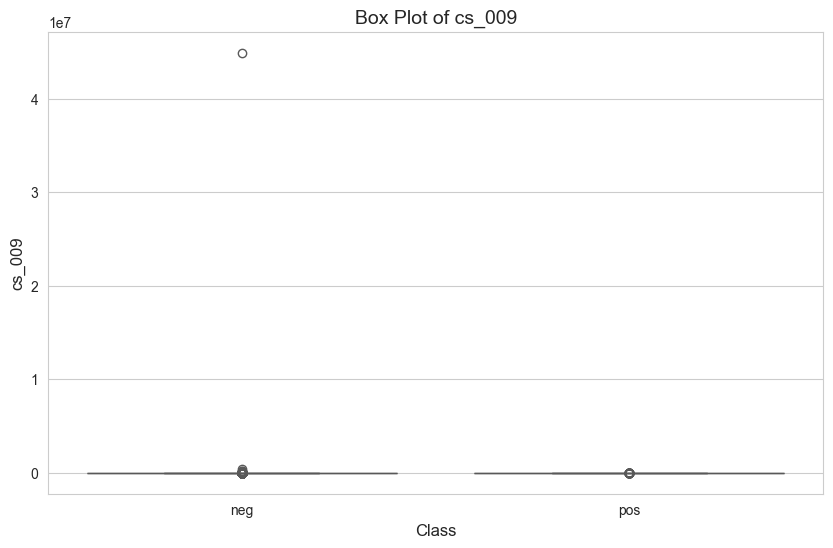

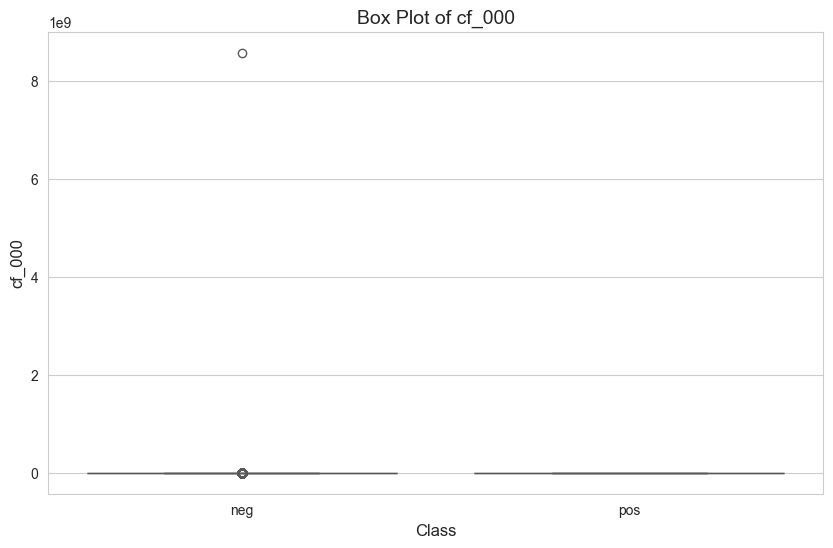

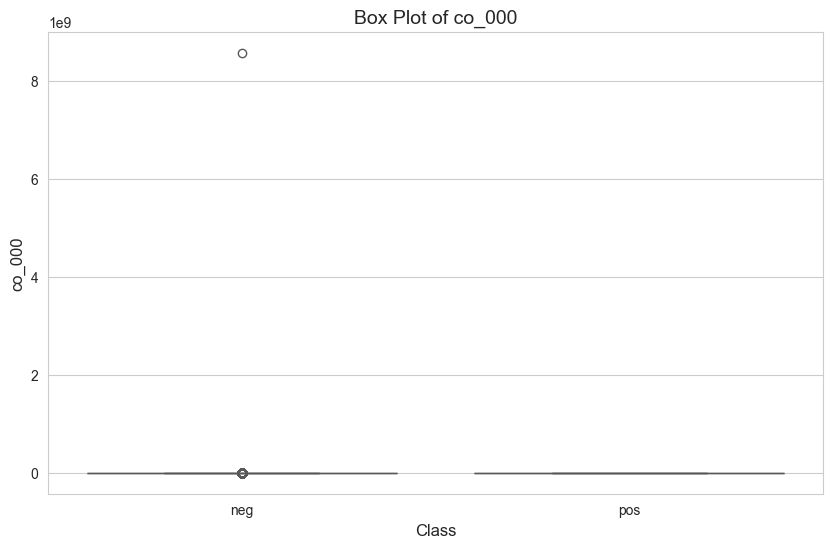

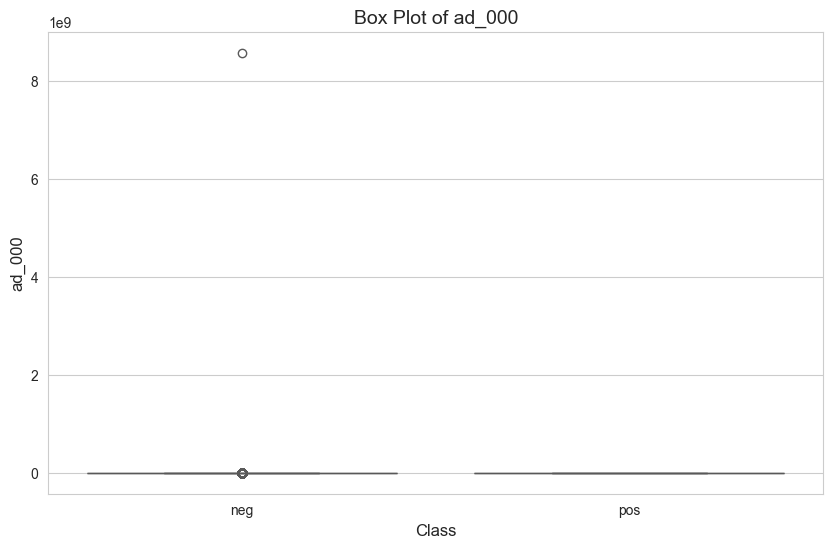

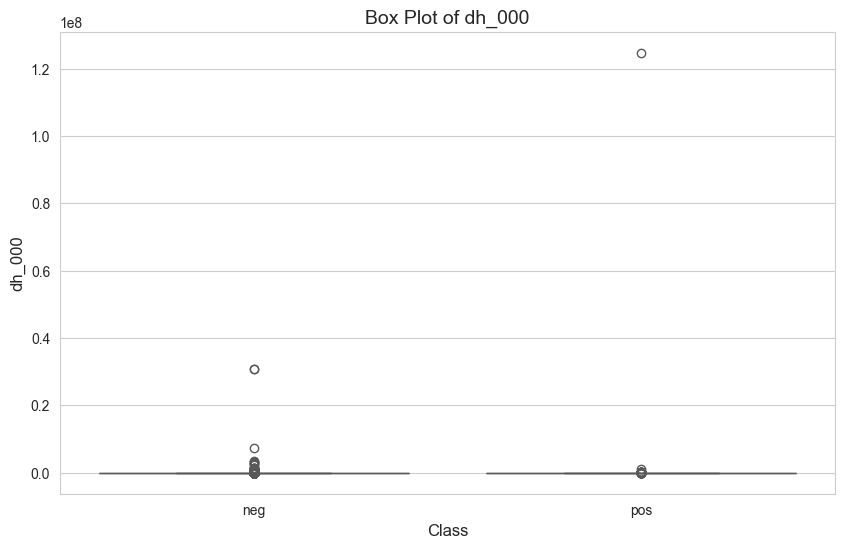

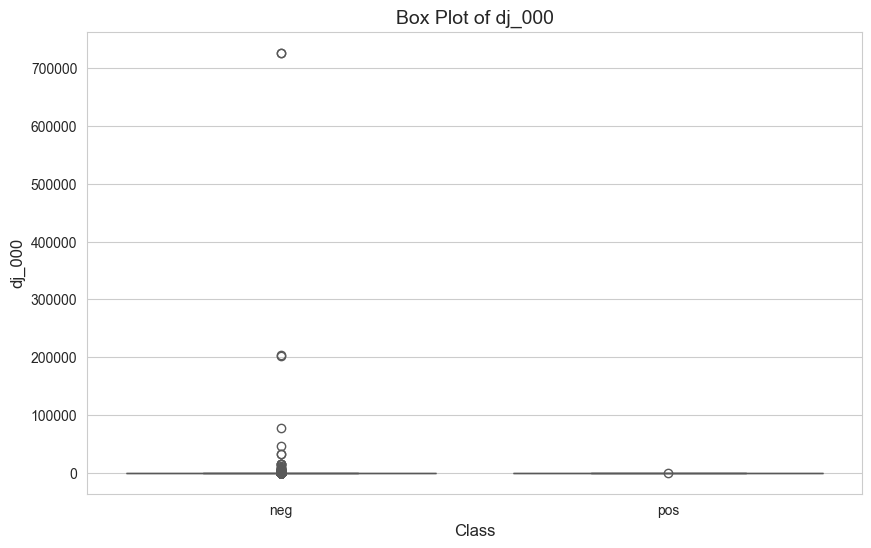

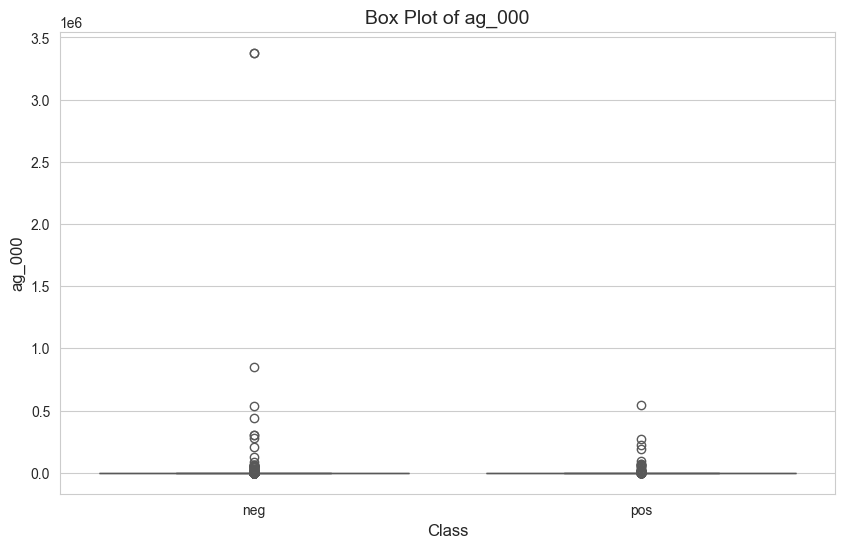

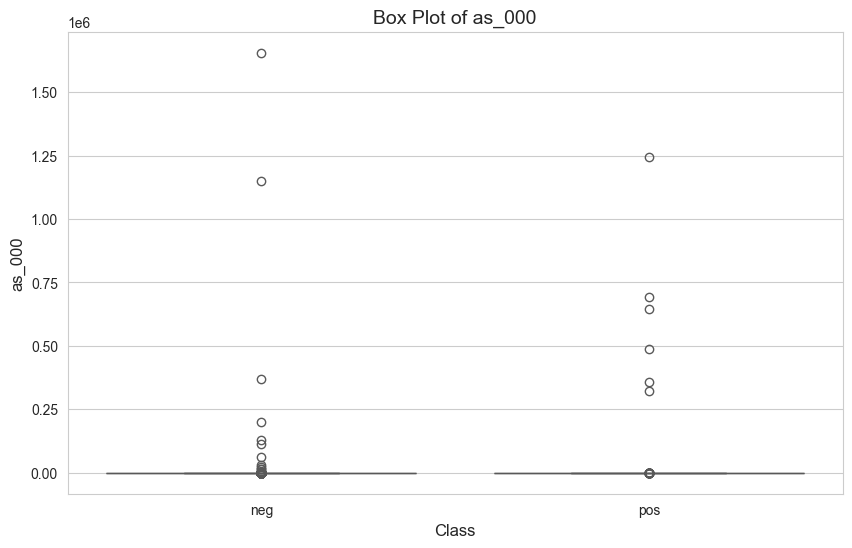

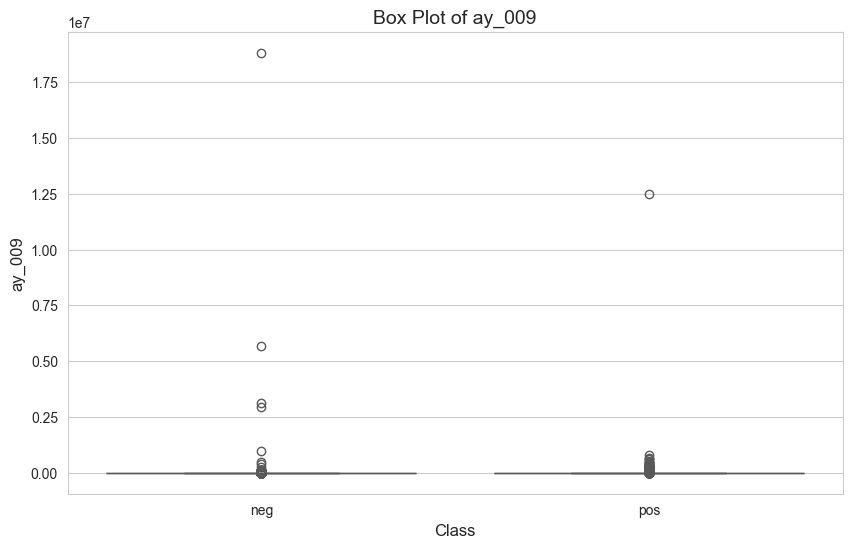

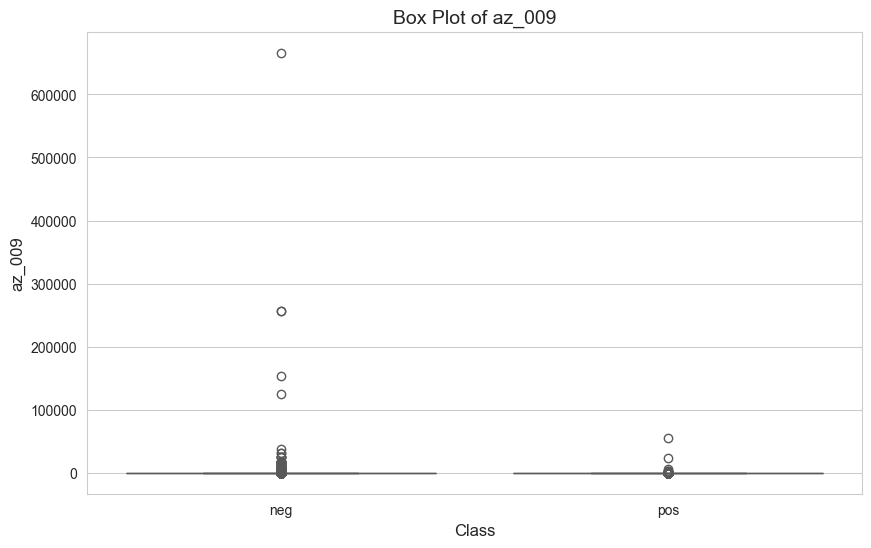

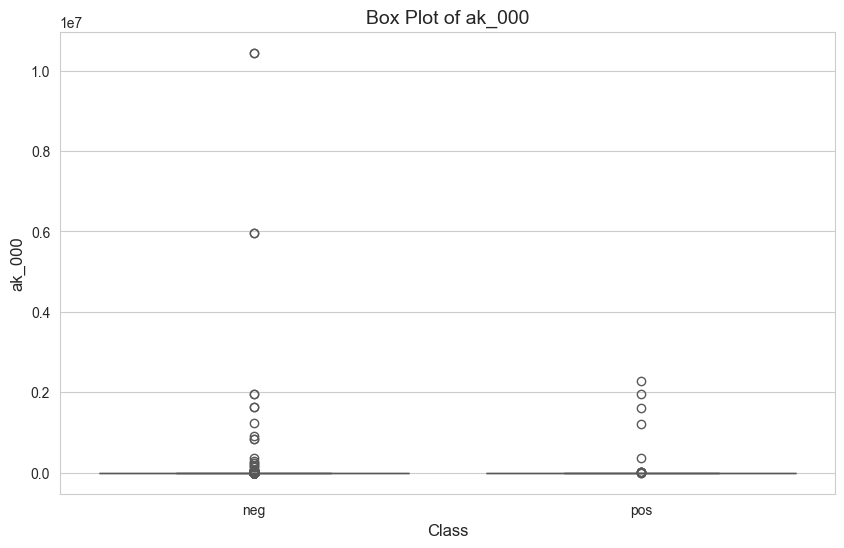

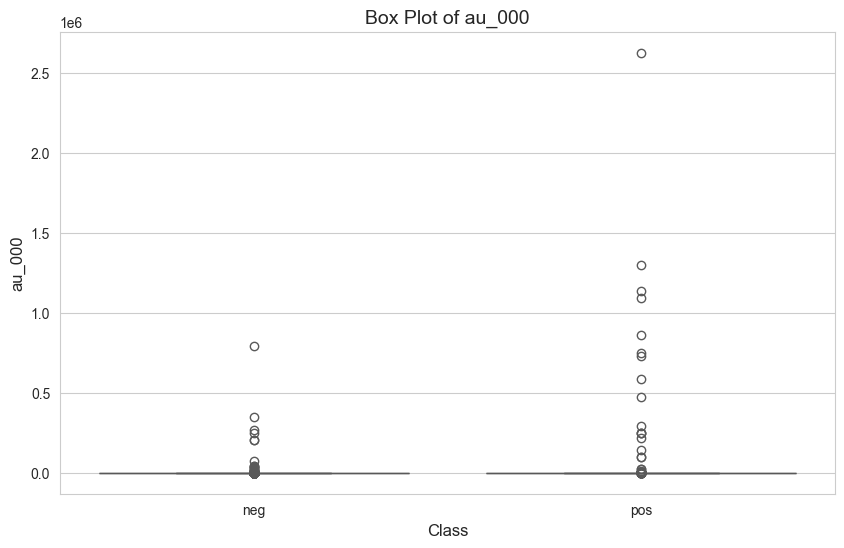

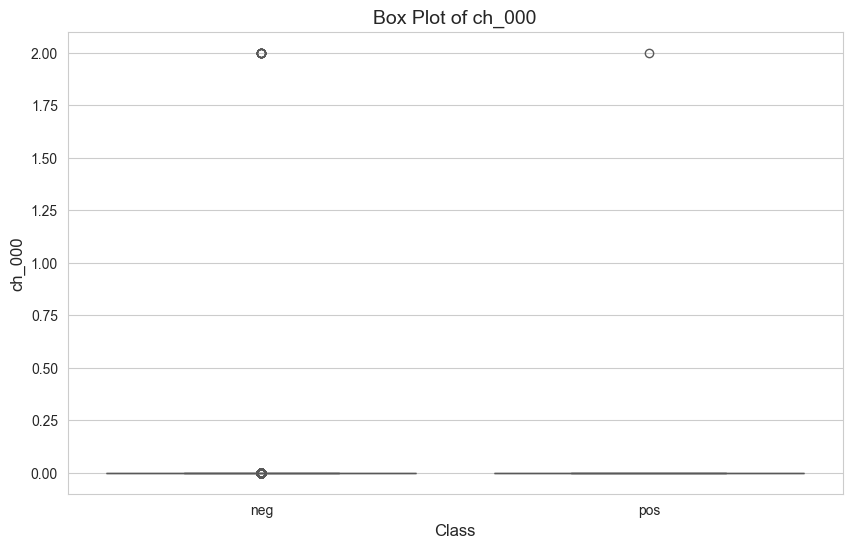

In [62]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Calculate the floor of the square root of the number of features (170)
numFeatures = math.floor(math.sqrt(170))

# Sort the CV values in descending order and get the top features
# Convert the dictionary into a list of tuples, sort by the CV value, and then take the top features
cvSorted = sorted(cvVals.items(), key=lambda item: item[1], reverse=True)
topFeatures = [feature for feature, cv in cvSorted[:numFeatures]]

# Create scatter plots for all combinations of the selected features
# Create pairs of features for plotting
featurePairs = list(itertools.combinations(topFeatures, 2))

# Plot scatter plots for each pair
for xFeature, yFeature in featurePairs:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=xFeature, y=yFeature, data=trainingData, hue='class', alpha=0.7, palette='Set1')
    plt.title(f'Scatter Plot of {xFeature} vs {yFeature}', fontsize=14)
    plt.xlabel(xFeature, fontsize=12)
    plt.ylabel(yFeature, fontsize=12)
    plt.legend(title='Class')
    plt.show()

# Now, create box plots for each of the top features
for feature in topFeatures:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y=feature, data=trainingData, palette='Set2')
    plt.title(f'Box Plot of {feature}', fontsize=14)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.show()

No substantive observations can be drawn from the scatterplots alone.

#### (v) Is this data set imbalanced?

In [63]:
trainingPosCount = trainingData['class'].value_counts().get('pos', 0)
trainingNegCount = trainingData['class'].value_counts().get('neg', 0)

testPosCount = testData['class'].value_counts().get('pos', 0)
testNegCount = testData['class'].value_counts().get('neg', 0)

print(f"Number of positive instances in training: {trainingPosCount}")
print(f"Number of negative instances in training: {trainingNegCount}")

print(f"Number of positive instances in testing: {testPosCount}")
print(f"Number of negative instances in testing: {testNegCount}")

Number of positive instances in training: 1000
Number of negative instances in training: 59000
Number of positive instances in testing: 375
Number of negative instances in testing: 15625


Both the training and testing data sets are imbalanced. There are way more negative instances than positive instances.

### (c) Train a random forest

Training Confusion Matrix:
 [[59000     0]
 [    0  1000]]
Test Confusion Matrix:
 [[15607    18]
 [  102   273]]
Training ROC AUC: 1.0
Test ROC AUC: 0.9930939733333334
Training Misclassification Rate: 0.0
Test Misclassification Rate: 0.007499999999999951
OOB Error Estimate: 0.005800000000000027
Test Error: 0.007499999999999951


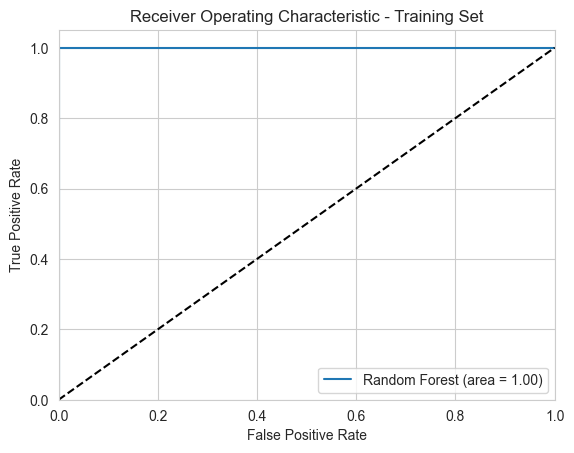

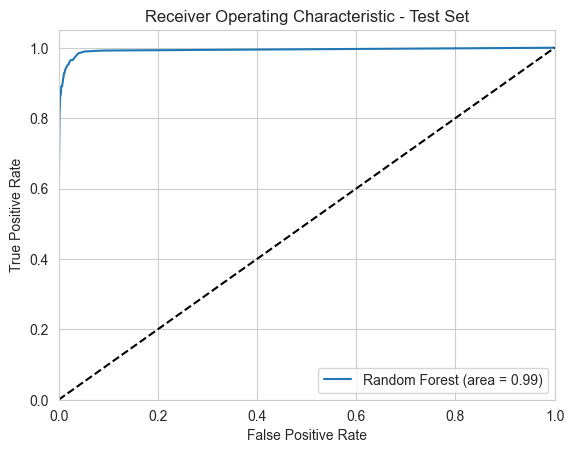

In [64]:
# Split the features and the target variable for training and test sets
xTrain = trainingData.drop('class', axis=1)
yTrain = trainingData['class'].apply(lambda x: 1 if x == 'pos' else 0)
xTest = testData.drop('class', axis=1)
yTest = testData['class'].apply(lambda x: 1 if x == 'pos' else 0)

# Initialize the Random Forest classifier with OOB score enabled to get the OOB error estimate
rfClassifier = RandomForestClassifier(oob_score=True, random_state=25)

# Train the classifier
rfClassifier.fit(xTrain, yTrain)

# Predict on training set and test set
trainPred = rfClassifier.predict(xTrain)
testPred = rfClassifier.predict(xTest)

# Calculate confusion matrices
trainCM = confusion_matrix(yTrain, trainPred)
testCM = confusion_matrix(yTest, testPred)

# Calculate the ROC AUC
trainAUC = roc_auc_score(yTrain, rfClassifier.predict_proba(xTrain)[:, 1])
testAUC = roc_auc_score(yTest, rfClassifier.predict_proba(xTest)[:, 1])

# Calculate the misclassification rate
trainMisclass = 1 - accuracy_score(yTrain, trainPred)
testMisclass = 1 - accuracy_score(yTest, testPred)

# Out of Bag error estimate
oobError = 1 - rfClassifier.oob_score_

# Compare OOB error to test error
testError = testMisclass

# Print results
print("Training Confusion Matrix:\n", trainCM)
print("Test Confusion Matrix:\n", testCM)
print(f"Training ROC AUC: {trainAUC}")
print(f"Test ROC AUC: {testAUC}")
print(f"Training Misclassification Rate: {trainMisclass}")
print(f"Test Misclassification Rate: {testMisclass}")
print(f"OOB Error Estimate: {oobError}")
print(f"Test Error: {testError}")

# Plot ROC Curve for Training set
fpr, tpr, _ = roc_curve(yTrain, rfClassifier.predict_proba(xTrain)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % trainAUC)
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training Set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC Curve for Test set
fpr, tpr, _ = roc_curve(yTest, rfClassifier.predict_proba(xTest)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % testAUC)
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()


### (d) Research class imbalance in random forest

Class Weights: Adjusting the weights of the classes in the loss function during training to give higher importance to the minority class.

Oversampling: Increasing the number of instances in the minority class by duplicating them or generating synthetic samples (SMOTE).

Undersampling: Reducing the number of instances in the majority class to balance the class distribution.

Balanced Random Forests: A variant of Random Forests where each tree is built from a bootstrap sample drawn from the original data in such a way that the classes are balanced.

Confusion Matrix (Training):
[[59000     0]
 [    0  1000]]

Confusion Matrix (Test):
[[15609    16]
 [  155   220]]

ROC AUC (Training): 1.0
ROC AUC (Test): 0.9932506453333334

Misclassification Rate (Training): 0.0
Misclassification Rate (Test): 0.010687499999999961

OOB Error Estimate: 0.00770000000000004


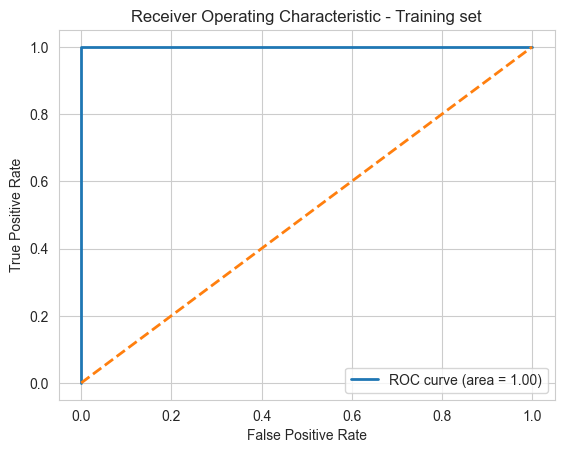

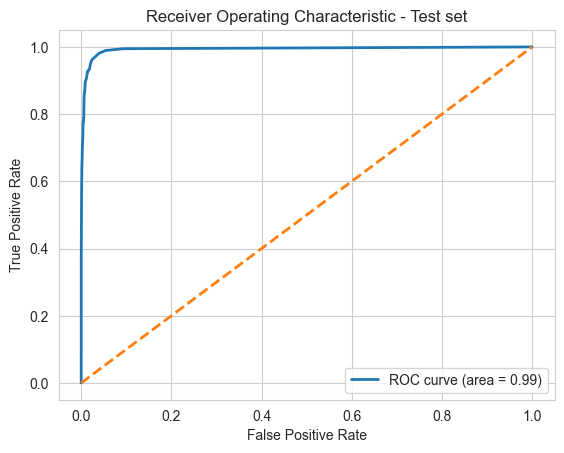

In [65]:
# Initialize the Random Forest classifier with class weights for balancing and OOB score enabled
rfClassifierBalanced = RandomForestClassifier(
    oob_score=True, 
    class_weight='balanced',  # Compensate for class imbalance
    random_state=25
)

# Train the classifier
rfClassifierBalanced.fit(xTrain, yTrain)

# Predict on training set and test set
trainPredBalanced = rfClassifierBalanced.predict(xTrain)
testPredBalanced = rfClassifierBalanced.predict(xTest)

# Previous Calculations

# Evaluate Confusion Matrix for training and test sets
trainCMBalanced = confusion_matrix(yTrain, trainPredBalanced)
testCMBalanced = confusion_matrix(yTest, testPredBalanced)

# Calculate ROC AUC for training and test sets
trainAUCBalanced = roc_auc_score(yTrain, rfClassifierBalanced.predict_proba(xTrain)[:, 1])
testAUCBalanced = roc_auc_score(yTest, rfClassifierBalanced.predict_proba(xTest)[:, 1])

# Calculate misclassification rate for training and test sets
trainMisclassBalanced = 1 - accuracy_score(yTrain, trainPredBalanced)
testMisclassBalanced = 1 - accuracy_score(yTest, testPredBalanced)

# Out of Bag error estimate
oobErrorBalanced = 1 - rfClassifierBalanced.oob_score_

# Display results
print("Confusion Matrix (Training):")
print(trainCMBalanced)

print("\nConfusion Matrix (Test):")
print(testCMBalanced)

print("\nROC AUC (Training):", trainAUCBalanced)
print("ROC AUC (Test):", testAUCBalanced)

print("\nMisclassification Rate (Training):", trainMisclassBalanced)
print("Misclassification Rate (Test):", testMisclassBalanced)

print("\nOOB Error Estimate:", oobErrorBalanced)

# Plot ROC curve for training set
fpr, tpr, _ = roc_curve(yTrain, rfClassifierBalanced.predict_proba(xTrain)[:, 1])
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {trainAUCBalanced:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(yTest, rfClassifierBalanced.predict_proba(xTest)[:, 1])
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {testAUCBalanced:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test set')
plt.legend(loc="lower right")
plt.show()

It appears that our classifier without accounting for imbalance performs better overall with a lower misclassification rate. This could be because the imbalanced forest classifies to negative more frequently to increase the accuracy.

### (e) XGBoost and Model Trees

Best alpha value: 0.5
Best CV accuracy: 0.9891188983050849
Confusion Matrix (Training): [[59000     0]
 [    1   999]]

Confusion Matrix (Test): [[15609    16]
 [   74   301]]

ROC AUC (Training): 0.9999984067796611
ROC AUC (Test): 0.9953455786666666

Misclassification Rate (Training): 1.666666666666483e-05
Misclassification Rate (Test): 0.005624999999999991


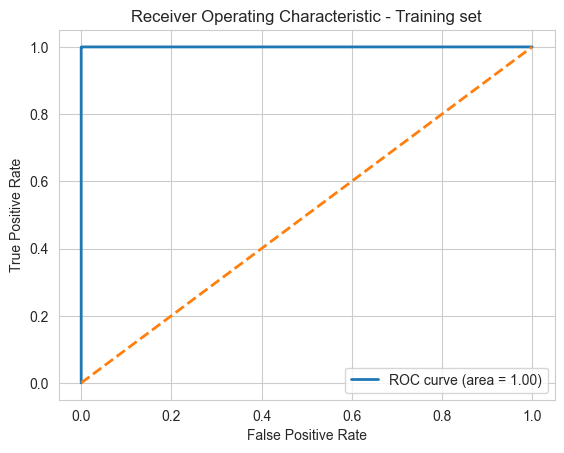

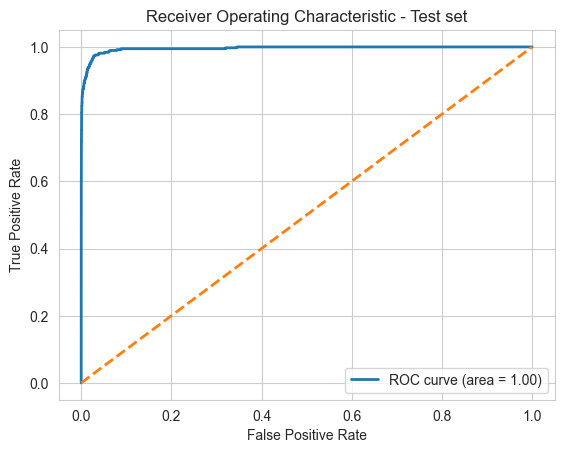

In [66]:
# Set up the XGBoost classifier with logistic regression objective
xgbModel = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up the parameter grid for cross-validation
paramGrid = {
    'reg_alpha': [.00001, .001, 0.1, .5, 1, 5, 10, 50, 100]
}

# Choose a cross-validation strategy
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

# Set up GridSearchCV to find the best alpha value
gridSearch = GridSearchCV(estimator=xgbModel, param_grid=paramGrid, scoring='roc_auc', n_jobs=-1, cv=kfold)

# Fit the grid search to the data
gridSearch.fit(xTrain, yTrain)

# Print out the best alpha value found
print(f"Best alpha value: {gridSearch.best_params_['reg_alpha']}")
print(f"Best CV accuracy: {gridSearch.best_score_}")

# Retrieve the best model
bestModel = gridSearch.best_estimator_

# Predict on training data
trainPred = bestModel.predict(xTrain)
trainProb = bestModel.predict_proba(xTrain)[:, 1]

# Predict on test data
testPred = bestModel.predict(xTest)
testProb = bestModel.predict_proba(xTest)[:, 1]

# Evaluate Confusion Matrix for training and test sets
cmTrain = confusion_matrix(yTrain, trainPred)
cmTest = confusion_matrix(yTest, testPred)

# Calculate ROC AUC for training and test sets
aucTrain = roc_auc_score(yTrain, trainProb)
aucTest = roc_auc_score(yTest, testProb)

trainMisclass = 1 - accuracy_score(yTrain, trainPred)
testMisclass = 1 - accuracy_score(yTest, testPred)

# Display results
print("Confusion Matrix (Training):", cmTrain)
print("\nConfusion Matrix (Test):", cmTest)

print("\nROC AUC (Training):", aucTrain)
print("ROC AUC (Test):", aucTest)

print("\nMisclassification Rate (Training):", trainMisclass)
print("Misclassification Rate (Test):", testMisclass)

# Plot ROC curve for training set
fpr, tpr, _ = roc_curve(yTrain, trainProb)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {aucTrain:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(yTest, testProb)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {aucTest:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test set')
plt.legend(loc="lower right")
plt.show()

Looking at the confusion matrices, XGBoost yields the best performance in the test set with a lower amount of false positive and negatives. It also has a slightly higher AUC than the other models, indicating better performance.

### (f) Use SMOTE to pre-process your data

In [67]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=25)
xTrainSmote, yTrainSmote = smote.fit_resample(xTrain, yTrain)

# Train the XGBoost model with L1 regularization (alpha parameter)
xgbSmote = xgb.XGBClassifier(objective='binary:logistic', reg_alpha=0.5, use_label_encoder=False, eval_metric='logloss')
xgbSmote.fit(xTrainSmote, yTrainSmote)

# Predictions for the test set
yTestPredSmote = xgbSmote.predict(xTest)
yTestProbASmote = xgbSmote.predict_proba(xTest)[:, 1]

# Evaluate the model's performance
cmTestSmote = confusion_matrix(yTest, yTestPredSmote)
aucTestSmote = roc_auc_score(yTest, yTestProbASmote)
testMisclassSmote = (yTest != yTestPredSmote).sum() / yTest.size

# Display the results
print(f"Confusion Matrix (Test) after SMOTE:\n{cmTestSmote}")
print(f"ROC AUC (Test) after SMOTE: {aucTestSmote}")
print(f"Misclassification Rate (Test) after SMOTE: {testMisclassSmote}")

print(f"Confusion Matrix (Test) before SMOTE:\n{cmTest}")
print(f"ROC AUC (Test) before SMOTE: {aucTest}")
print(f"Misclassification Rate (Test) before SMOTE: {testMisclass}")

Confusion Matrix (Test) after SMOTE:
[[15582    43]
 [   66   309]]
ROC AUC (Test) after SMOTE: 0.9940860586666667
Misclassification Rate (Test) after SMOTE: 0.0068125
Confusion Matrix (Test) before SMOTE:
[[15609    16]
 [   74   301]]
ROC AUC (Test) before SMOTE: 0.9953455786666666
Misclassification Rate (Test) before SMOTE: 0.005624999999999991


## 2. ISLR 6.6.3

a) The training RSS will steadily decrease. The value of the estimated coefficients will increase from 0 to their OLS value when the value of s increases. Thus, RSS will decrease.

b) The test RSS will decrease initially and then eventually start increasing in a U shape. The test RSS will decrease, then it will hit an inflection point and the test residual sum error will increase.

c) Variance will steadily increase. At first, β will be close to 0 and after the model becomes flexible, the variance will increase.

d) Squared bias will steadily decrease. Due to the bias-variance trade-off, since the variance is increasing, the bias will decrease.

e) Irreducible error will remain constant as it is present in any ML model and can not really be affected. 

## 3. ISLR 6.6.5

## 4. ISLR 8.4.5

Using a majority vote approach, probabilities >= 0.5 will be true and probabilities < 0.5 will be false.
Votes for Red (P >= 0.5): 0.55, 0.6, 0.6, 0.65, 0.7, 0.75 → 6 votes
Votes for Green (P < 0.5): 0.1, 0.15, 0.2, 0.2 → 4 votes
The majority votes are for Red (6 out of 10), so the majority vote prediction is red.

Using the average probability approach, we calculate the mean of the probabilities and then classify the instance based on whether this mean is above or below the threshold of 0.5.

The average probability is:
(0.1 + 0.15 + 0.2 + 0.2 + 0.55 + 0.6 + 0.6 + 0.65 + 0.7 + 0.75) / 10 = 0.45
Thus, the prediction is green.

## 5. ISLR 9.7.3